<a href="https://colab.research.google.com/github/kstrickland680/MentalHealthRedditAnalysis/blob/main/MentalHealthRedditAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
pip install Unidecode

In [167]:
pip install contractions

In [168]:
pip install -U sentence-transformers

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.7/dist-packages (1.2.0)


In [269]:
import requests
import pandas as pd
import json
import csv
import time
import datetime
import numpy as np
import regex as re
from collections import Counter
from bs4 import BeautifulSoup
import spacy
from unidecode import unidecode
import contractions
import re
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec
import matplotlib.pyplot as plt
from collections import Counter
import pprint

from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras import layers, models

import pickle
from sentence_transformers import SentenceTransformer

import keras
from keras.utils import np_utils
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model

import seaborn as sns



nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Mental Health Reddit Analysis 

Problem Statement:  A nonprofit agency is interested in new ways to assess mental health using social media.  They want a way to assess someone's mental health using their social media posts.

Can we predict if someone has a certain mental illness based on their social media posts about things unrelated to their mental illness?

## Data Overview

Data will be gathered from Reddit.   Users who post in the following subreddits: PTSD, ADHD, Anxiety, BPD, BipolarReddit, and Depression, as well as a control group chosen randomly from other subreddits that those in the experimental group also post to.
Users will be labeled based on flair in subreddits that require users to flag themselves as friend/family member or undiagnosed (BipolarReddit and bpd). Those without that flair will be labeled as having the disorder.   In the other 4 subreddits, self-reported diagnoses will be used to identify users with the disorder (such as "I was diagnosed with depression", "my depression", etc). Anxiety will not be based on an official diagnosis, but instead on those users who speak about struggling with anxiety (as the problem statement specifies mental health in general, not necessarily diagnosable mental health).  Data will then be gathered from these users' posts in unrelated subreddits.

In [170]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Data

I import the the data for the users that self-identify as having the specified mental illness.  I then make a list of the subreddits they post in most often (not explicitly related to mental health), and export that data to gather the control data. 

In [171]:
cd drive/MyDrive/MentalHealthRedditAnalysis/Data/

[Errno 2] No such file or directory: 'drive/MyDrive/MentalHealthRedditAnalysis/Data/'
/content/drive/MyDrive/MentalHealthRedditAnalysis/Data


In [172]:
#importing the "experimental" classes for each mental health group, for both comments and subs
anxiety_coms_df = pd.read_csv('anxiety_coms.csv')
anxiety_subs_df = pd.read_csv('anxiety_subs.csv')

adhd_coms_df = pd.read_csv('adhd_coms.csv')
adhd_subs_df = pd.read_csv('adhd_subs.csv')

bipolar_coms_df = pd.read_csv('bipolar_coms.csv')
bipolar_subs_df = pd.read_csv('bipolar_subs.csv')

bpd_coms_df = pd.read_csv('bpd_coms.csv')
bpd_subs_df = pd.read_csv('bpd_subs.csv')

dep_coms_df = pd.read_csv('dep_coms.csv')
dep_subs_df = pd.read_csv('dep_subs.csv')

ptsd_coms_df = pd.read_csv('ptsd_coms.csv')
ptsd_subs_df = pd.read_csv('ptsd_subs.csv')

In [173]:
dep_subs_df.head()

,Unnamed: 0,sub_id,author,title,url,score,created,created_utc,numComms,permalink,flair,selftex,subreddit
0,0,k40gmp,778,"After breakup, I feel completely numb, is this...",https://www.reddit.com/r/relationship_advice/c...,1,2020-11-30 17:29:42,1606757382,2,/r/relationship_advice/comments/k40gmp/after_b...,NaN,[removed],relationship_advice
1,1,k416rs,778,I’ve been feeling numb since my breakup that h...,https://www.reddit.com/r/relationship_advice/c...,1,2020-11-30 18:00:53,1606759253,2,/r/relationship_advice/comments/k416rs/ive_bee...,NaN,[removed],relationship_advice
2,2,k41j0f,778,"Why is this happening? After breakup, I feel c...",https://www.reddit.com/r/relationship_advice/c...,1,2020-11-30 18:15:51,1606760151,3,/r/relationship_advice/comments/k41j0f/why_is_...,NaN,"\nFeeling numb after breakup, is this a normal...",relationship_advice
3,3,k4b7mu,778,"Why is this happening? After breakup, I feel c...",https://www.reddit.com/r/relationship_advice/c...,1,2020-12-01 02:10:18,1606788618,1,/r/relationship_advice/comments/k4b7mu/why_is_...,NaN,"\n\nFeeling numb after breakup, is this a norm...",relationship_advice
4,4,k4rqs5,778,I don’t know why this is happening. It’s been ...,https://www.reddit.com/r/relationship_advice/c...,1,2020-12-01 19:13:17,1606849997,9,/r/relationship_advice/comments/k4rqs5/i_dont_...,NaN,"I’m confused about my feelings. So, I have a h...",relationship_advice


In [174]:
#helper functions to count how popular subreddits are
def combineSubreddits(dict, dict2):
  """ combines 2 dictionaries, adds the values in both if they exist in both """
  for key, value in dict2.items():
    if key in dict:
      new_count = dict.get(key) + value
      dict[key] = new_count
    else:
      dict[key] = value

In [175]:
def getSubredditCounts(df1, df2):
  """ Gets the subreddit columns from 2 data frames and combines them together,
  returning a dictionary of the value and count. """ 
  count1 = df1['subreddit'].value_counts()
  count2 = df2['subreddit'].value_counts()
  count1 = count1.to_dict()
  count2 = count2.to_dict()
  final = count2
  combineSubreddits(final, count1)
  return final

In [176]:
ptsd_subreddits = getSubredditCounts(ptsd_subs_df, ptsd_coms_df)
anxiety_subreddits = getSubredditCounts(anxiety_subs_df, anxiety_coms_df)
dep_subreddits = getSubredditCounts(dep_subs_df, dep_coms_df)
adhd_subreddits = getSubredditCounts(adhd_subs_df, adhd_coms_df)
bipolar_subreddits = getSubredditCounts(bipolar_subs_df, bipolar_coms_df)
bpd_subreddits = getSubredditCounts(bpd_subs_df, bpd_coms_df)

In [177]:
#now combine them all for a master list: 
partial_subreddit_list = [anxiety_subreddits, dep_subreddits, adhd_subreddits,
                  bipolar_subreddits, bpd_subreddits]

all_subreddits = ptsd_subreddits
for item in partial_subreddit_list:
  combineSubreddits(all_subreddits, item)

all_subreddits['atheism']

43

In [178]:
#sort the list in terms of frequency 
all_subreddits_sorted = sorted(all_subreddits.items(), key=lambda x: x[1], reverse=True)
all_subreddits_sorted

[('AskReddit', 5522),
 ('BipolarReddit', 3818),
 ('ADHD', 2936),
 ('Anxiety', 2105),
 ('BPD', 1866),
 ('depression', 1840),
 ('ptsd', 1384),
 ('relationship_advice', 1242),
 ('bipolar', 1186),
 ('teenagers', 1056),
 ('AmItheAsshole', 846),
 ('CPTSD', 752),
 ('unpopularopinion', 730),
 ('relationships', 640),
 ('Advice', 630),
 ('memes', 600),
 ('SuicideWatch', 592),
 ('NoStupidQuestions', 557),
 ('mentalhealth', 506),
 ('raisedbynarcissists', 484),
 ('BPDmemes', 442),
 ('trees', 438),
 ('offmychest', 428),
 ('aww', 428),
 ('wallstreetbets', 421),
 ('bipolar2', 392),
 ('selfharm', 387),
 ('RedditSessions', 377),
 ('MadeOfStyrofoam', 368),
 ('AskDocs', 359),
 ('sex', 344),
 ('Drugs', 342),
 ('cats', 305),
 ('dogecoin', 294),
 ('AskWomen', 283),
 ('NoFap', 283),
 ('funny', 275),
 ('TrueOffMyChest', 266),
 ('Showerthoughts', 265),
 ('NarcissisticAbuse', 262),
 ('dating_advice', 254),
 ('pics', 251),
 ('playboicarti', 251),
 ('AskMen', 240),
 ('PublicFreakout', 236),
 ('OCD', 235),
 ('TwoXC

In [179]:
#only keep the subreddits that at least 50 users have posted to for the list to gather control data from
all_subreddits_above50 = {key:val for key, val in all_subreddits.items() if val >= 50}
len(all_subreddits_above50)


423

In [180]:
#removing subreddits related to menal health 

subreddits_todelete = ['BipolarReddit', 'depressed', 'ADHD', 'Anxiety', 'BPD', 'ptsd', 'bipolar', 'depression', 'CPTSD',
'mentalhealth', 'BPDmemes', 'SuicideWatch','bipolar', 'bipolar2', 'raisedbynarcissists', 'depression_memes',
'selfharm', 'NarcissisticAbuse', 'OCD', 'BorderlinePDisorder', 'zoloft', 'adhdwomen', 
'BipolarSOs', 'aspergers', 'BPDlite','AskPsychiatry',  'therapy', 'insomnia', 'adhdmeme', 'prozac',
'lexapro', 'TalkTherapy', 'HealthAnxiety', 'benzodiazepines', 'mentalillness', 'BPDlovedones',
'autism', 'schizophrenia', 'socialanxiety','Anxietyhelp', 'antidepressants', 'Psychosis', 'bulimia',
'BodyDysmorphia',  'SelfHarmScars', 'transOCD', 'dpdr', 'depressionregimens', 'bupropion', 'AnorexiaRecovery',
'schizoaffective', 'AnxiousAttachment', 'AnorexiaNervosa', 'EDAnonymous', 'EDanonymemes','desabafos', 'de' ]

subreddits_for_control_group = list(all_subreddits_above50.keys())
subreddits_for_control_group = [x for x in subreddits_for_control_group if x not in subreddits_todelete]
len(subreddits_for_control_group)

370

In [181]:
subreddits_for_control_group

['AskReddit',
 'AmItheAsshole',
 'teenagers',
 'relationship_advice',
 'relationships',
 'offmychest',
 'aww',
 'NoStupidQuestions',
 'unpopularopinion',
 'pics',
 'PurplePillDebate',
 'todayilearned',
 'Advice',
 'AskTeenGirls',
 'hiphopheads',
 'bois',
 'AskWomen',
 'trees',
 'stopdrinking',
 'PokemonTCG',
 'funny',
 'gonewild',
 'MaddenUltimateTeam',
 'worldnews',
 'WTF',
 'loseit',
 'childfree',
 'Depop',
 'trumpet',
 'lawofattraction',
 'AskWomenOver30',
 'Hamilton',
 'askanincel',
 'homestuck',
 'asktrp',
 'Aquariums',
 'PoliticalCompassMemes',
 'sex',
 'MakeNewFriendsHere',
 'AskDocs',
 'asktransgender',
 'Eberron',
 'randomactsofamazon',
 'Showerthoughts',
 'RealEstate',
 'actuallesbians',
 'MakeupAddiction',
 'CBD',
 'ImaginaryHorrors',
 'politics',
 'survivor',
 'thesims',
 'FreeCompliments',
 'WWEGames',
 'ExNoContact',
 'memes',
 'dogecoin',
 'weed',
 'UnsentLetters',
 'confession',
 'AskMen',
 'intj',
 'nba',
 'GERD',
 'gifs',
 'JUSTNOMIL',
 'TeenMomOGandTeenMom2',
 'Tumbl

## Data Combination

I create a label for each class, and apply it as necessary. 

In [182]:
classes = {'anxiety': 1, 'adhd': 2, 'bipolar': 3, 'bpd': 4, 'depression': 5, 'ptsd': 6, 'control': 0}

In [183]:
anxiety_subs_df['class'] = 1
anxiety_coms_df['class'] = 1
adhd_subs_df['class'] = 2
adhd_coms_df['class'] = 2
bipolar_subs_df['class'] = 3
bipolar_coms_df['class'] = 3
bpd_coms_df['class'] = 4
bpd_subs_df['class'] = 4
dep_coms_df['class'] = 5
dep_subs_df['class'] = 5
ptsd_coms_df['class'] = 6
ptsd_subs_df['class'] = 6

In [184]:
anxiety_coms_df.head()

,Unnamed: 0,com_id,author,score,created,created_utc,url,body,subreddit,class
0,0,gcvp6f9,3045,2,2020-11-19 22:36:34,1605825394,/r/Anxiety/comments/jxc8vp/how_come_after_i_wa...,Yeah you are right it’s probably my brain anti...,Anxiety,1
1,1,gcw1cwq,3045,1,2020-11-20 00:10:50,1605831050,/r/latinas/comments/jxdt28/what_do_you_think_a...,Weak,latinas,1
2,2,gcw94v3,3045,1,2020-11-20 01:22:45,1605835365,/r/Anxiety/comments/jxeq5h/can_anxiety_general...,Yes. For me when my anxiety started after havi...,Anxiety,1
3,3,gcyec2m,3045,1,2020-11-20 16:42:34,1605890554,/r/DaniellePertusiello/comments/jsu516/hooters...,What’s her new ig,DaniellePertusiello,1
4,4,gcyoq7d,3045,1,2020-11-20 18:04:59,1605895499,/r/Anxiety/comments/jxtpgy/always_lightheadedd...,Yes I find myself kind of light headed and diz...,Anxiety,1


In [185]:
def prepareDataFrame(df, type):
  """ Takes in a Dataframe and type (submission or comment).  Returns new data frame that has removed entries 
  from mentalhealth subreddits and posts than 50 words long. """
  #remove subreddits related to mental health 
  return_df = df.loc[~df['subreddit'].isin(subreddits_todelete)]

  #create word count column
  if type == ('sub'):
    try:
      return_df['word_count'] = return_df['selftext'].str.split().str.len()
    except:
      return_df['word_count'] = return_df['selftex'].str.split().str.len()
      return_df['selftext'] = return_df['selftex']
  else:
    return_df['word_count'] = return_df['body'].str.split().str.len()

  #remove rows with text less than 50 words
  return_df = return_df.loc[return_df['word_count'] >= 50]

  return return_df


In [186]:
#Dataframes of comment data with comments shorter than 50 words removed, and with comments in mental health subreddits remved 
anxiety_coms_df_shortened = prepareDataFrame(anxiety_coms_df, 'com')
bpd_coms_df_shortened = prepareDataFrame(bpd_coms_df, 'com')
bipolar_coms_df_shortened = prepareDataFrame(bipolar_coms_df, 'com')
dep_coms_df_shortened = prepareDataFrame(dep_coms_df, 'com')
adhd_coms_df_shortened = prepareDataFrame(adhd_coms_df, 'com')
ptsd_coms_df_shortened = prepareDataFrame(ptsd_coms_df, 'com')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [187]:
#Dataframes of Submission data with comments shorter than 50 words removed, and with comments in mental health subreddits remved 

anxiety_subs_df_shortened = prepareDataFrame(anxiety_subs_df, 'sub')
bpd_subs_df_shortened = prepareDataFrame(bpd_subs_df, 'sub')
bipolar_subs_df_shortened = prepareDataFrame(bipolar_subs_df, 'sub')
dep_subs_df_shortened = prepareDataFrame(dep_subs_df, 'sub')
adhd_subs_df_shortened = prepareDataFrame(adhd_subs_df, 'sub')
ptsd_subs_df_shortened = prepareDataFrame(ptsd_subs_df, 'sub')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [188]:
anxiety_subs_df_shortened.head()

,Unnamed: 0,sub_id,author,title,url,score,created,created_utc,numComms,permalink,flair,selftex,subreddit,class,word_count,selftext
1,1,lm55xj,3045,Quick Question on fake percs,https://www.reddit.com/r/opiates/comments/lm55...,1,2021-02-17 21:27:01,1613597221,17,/r/opiates/comments/lm55xj/quick_question_on_f...,NaN,So a homie of mine got some suspect looking pe...,opiates,1,66.0,So a homie of mine got some suspect looking pe...
3,3,mkvmp8,3045,Noob,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-05 21:39:26,1617658766,5,/r/HappyEndingMassage/comments/mkvmp8/noob/,NaN,"I’m 23, short and people have said I looked li...",HappyEndingMassage,1,52.0,"I’m 23, short and people have said I looked li..."
4,4,mmf49y,3045,Scored First Time,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-07 23:45:20,1617839120,3,/r/HappyEndingMassage/comments/mmf49y/scored_f...,NaN,I’ve never done this before but decided to giv...,HappyEndingMassage,1,53.0,I’ve never done this before but decided to giv...
5,5,mmveji,3045,Need FS or atleast BBBBJ,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-08 16:22:20,1617898940,7,/r/HappyEndingMassage/comments/mmveji/need_fs_...,NaN,How do I go about getting FS or BJ. Just went ...,HappyEndingMassage,1,54.0,How do I go about getting FS or BJ. Just went ...
6,6,mn1enc,3045,How to avoid ever getting caught by Leo’s,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-08 21:00:19,1617915619,3,/r/HappyEndingMassage/comments/mn1enc/how_to_a...,Question,I’m new to this and did some research and foun...,HappyEndingMassage,1,52.0,I’m new to this and did some research and foun...


## Import Negative Group

I import the control data and create dataframes for it. 


In [189]:
first_threethousand_coms_df = pd.read_csv('first_threethousand_coms.csv')
threetofourthousand_coms_df = pd.read_csv('threetofourthousand_coms.csv')
fourthousandtotenthousand_coms_df = pd.read_csv('fourthousandtotenthousand_coms.csv')
tenthousandthrutwentythousand_coms_df = pd.read_csv('tenthousandthrutwentythousand_coms.csv')
twentythousandthruthirtythousand_coms_df = pd.read_csv('twentythousandthruthirtythousand_coms.csv')
thirtythousandthrufourtyfivethousand_coms_df = pd.read_csv('thirtythousandthrufourtyfivethousand_coms.csv')
fourtyfivethouthrufiftyfivetho_coms_df = pd.read_csv('fourtyfivethouthrufiftyfivetho_coms.csv')
fiftyfivethoutosixtyfivethou_coms_df = pd.read_csv('fiftyfivethoutosixtyfivethou_coms.csv')
sixtyfivethouthruseventyfivethou_coms_df = pd.read_csv('sixtyfivethouthruseventyfivethou_coms.csv')
seventyfivethouthrueightyfivethou_coms_df = pd.read_csv('seventyfivethouthrueightyfivethou_coms.csv')

In [190]:
first_threethousand_coms_df = prepareDataFrame(first_threethousand_coms_df, 'com')
threetofourthousand_coms_df = prepareDataFrame(threetofourthousand_coms_df, 'com')
fourthousandtotenthousand_coms_df = prepareDataFrame(fourthousandtotenthousand_coms_df, 'com')
tenthousandthrutwentythousand_coms_df = prepareDataFrame(tenthousandthrutwentythousand_coms_df, 'com')
twentythousandthruthirtythousand_coms_df = prepareDataFrame(twentythousandthruthirtythousand_coms_df, 'com')
thirtythousandthrufourtyfivethousand_coms_df = prepareDataFrame(thirtythousandthrufourtyfivethousand_coms_df, 'com')
fourtyfivethouthrufiftyfivetho_coms_df = prepareDataFrame(fourtyfivethouthrufiftyfivetho_coms_df, 'com')
fiftyfivethoutosixtyfivethou_coms_df = prepareDataFrame(fiftyfivethoutosixtyfivethou_coms_df, 'com')
sixtyfivethouthruseventyfivethou_coms_df = prepareDataFrame(sixtyfivethouthruseventyfivethou_coms_df, 'com')
seventyfivethouthrueightyfivethou_coms_df = prepareDataFrame(seventyfivethouthrueightyfivethou_coms_df, 'com')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [191]:
frames = [first_threethousand_coms_df, threetofourthousand_coms_df, fourthousandtotenthousand_coms_df,
          tenthousandthrutwentythousand_coms_df, twentythousandthruthirtythousand_coms_df, thirtythousandthrufourtyfivethousand_coms_df,
          fourtyfivethouthrufiftyfivetho_coms_df, fiftyfivethoutosixtyfivethou_coms_df, sixtyfivethouthruseventyfivethou_coms_df,
          seventyfivethouthrueightyfivethou_coms_df]

control_df = pd.concat(frames, ignore_index=True)
control_df['class'] = 0
len(control_df)

306815

In [192]:
firsttenthou_subs_df = pd.read_csv('firsttenthou_subs.csv')
tenthouthruwentythou_subs_df = pd.read_csv('tenthouthruwentythou_subs.csv')
twentythouthruthirtythou_subs_df = pd.read_csv('twentythouthruthirtythou_subs.csv')
thirtythouthrufourtythou_subs_df = pd.read_csv('thirtythouthrufourtythou_subs.csv')
fourtythouthrufiftythou_subs_df = pd.read_csv('fourtythouthrufiftythou_subs.csv')
fiftythouthrusixtythou_subs_df = pd.read_csv('fiftythouthrusixtythou_subs.csv')
sixtythouthruseventythou_subs_df = pd.read_csv('sixtythouthruseventythou_subs.csv')
seventythouthrueightythou_subs_df = pd.read_csv('seventythouthrueightythou_subs.csv')
eightythouthrueightyfivethou_subs_df = pd.read_csv('eightythouthrueightyfivethou.csv')

In [193]:

firsttenthou_subs_df = prepareDataFrame(firsttenthou_subs_df, 'sub')
tenthouthruwentythou_subs_df = prepareDataFrame(tenthouthruwentythou_subs_df, 'sub')
twentythouthruthirtythou_subs_df =  prepareDataFrame(twentythouthruthirtythou_subs_df, 'sub')
thirtythouthrufourtythou_subs_df = prepareDataFrame(thirtythouthrufourtythou_subs_df, 'sub')
fourtythouthrufiftythou_subs_df = prepareDataFrame(fourtythouthrufiftythou_subs_df, 'sub')
fiftythouthrusixtythou_subs_df = prepareDataFrame(fiftythouthrusixtythou_subs_df, 'sub')
sixtythouthruseventythou_subs_df = prepareDataFrame(sixtythouthruseventythou_subs_df, 'sub')
seventythouthrueightythou_subs_df = prepareDataFrame(seventythouthrueightythou_subs_df, 'sub')
eightythouthrueightyfivethou_subs_df = prepareDataFrame(eightythouthrueightyfivethou_subs_df, 'sub')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

### Important Dataframes

All_comdata_df contains the comment data we'll be analyzing 

sub_df contains the submission data. 

all_df contains both.  

In [194]:
frames_sub_con = [firsttenthou_subs_df, tenthouthruwentythou_subs_df, twentythouthruthirtythou_subs_df,
                  thirtythouthrufourtythou_subs_df, fourtythouthrufiftythou_subs_df, fiftythouthrusixtythou_subs_df,
                  sixtythouthruseventythou_subs_df, seventythouthrueightythou_subs_df, eightythouthrueightyfivethou_subs_df]

subs_control_df = pd.concat(frames_sub_con, ignore_index=True)
subs_control_df['class'] = 0
len(subs_control_df)

45322

In [195]:
frames_coms = [anxiety_coms_df_shortened, bpd_coms_df_shortened, bipolar_coms_df_shortened, dep_coms_df_shortened,
          adhd_coms_df_shortened, ptsd_coms_df_shortened, control_df]

all_comdata_df = pd.concat(frames_coms, ignore_index=True)

In [196]:
frames_sub = [anxiety_subs_df_shortened, bpd_subs_df_shortened, bipolar_subs_df_shortened, dep_subs_df_shortened,
              adhd_subs_df_shortened, ptsd_subs_df_shortened, subs_control_df]
sub_df = pd.concat(frames_sub, ignore_index=True)
sub_df.head()

,Unnamed: 0,sub_id,author,title,url,score,created,created_utc,numComms,permalink,flair,selftex,subreddit,class,word_count,selftext
0,1,lm55xj,3045,Quick Question on fake percs,https://www.reddit.com/r/opiates/comments/lm55...,1,2021-02-17 21:27:01,1613597221,17,/r/opiates/comments/lm55xj/quick_question_on_f...,NaN,So a homie of mine got some suspect looking pe...,opiates,1,66.0,So a homie of mine got some suspect looking pe...
1,3,mkvmp8,3045,Noob,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-05 21:39:26,1617658766,5,/r/HappyEndingMassage/comments/mkvmp8/noob/,NaN,"I’m 23, short and people have said I looked li...",HappyEndingMassage,1,52.0,"I’m 23, short and people have said I looked li..."
2,4,mmf49y,3045,Scored First Time,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-07 23:45:20,1617839120,3,/r/HappyEndingMassage/comments/mmf49y/scored_f...,NaN,I’ve never done this before but decided to giv...,HappyEndingMassage,1,53.0,I’ve never done this before but decided to giv...
3,5,mmveji,3045,Need FS or atleast BBBBJ,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-08 16:22:20,1617898940,7,/r/HappyEndingMassage/comments/mmveji/need_fs_...,NaN,How do I go about getting FS or BJ. Just went ...,HappyEndingMassage,1,54.0,How do I go about getting FS or BJ. Just went ...
4,6,mn1enc,3045,How to avoid ever getting caught by Leo’s,https://www.reddit.com/r/HappyEndingMassage/co...,1,2021-04-08 21:00:19,1617915619,3,/r/HappyEndingMassage/comments/mn1enc/how_to_a...,Question,I’m new to this and did some research and foun...,HappyEndingMassage,1,52.0,I’m new to this and did some research and foun...


In [197]:
final_frames = [sub_df, all_comdata_df]

In [198]:
all_df = pd.concat(final_frames, ignore_index=True) #dataframe for both comment and submission data, including control


In [199]:
all_comdata_df.head() #dataframe for all comment data, including control 

,Unnamed: 0,com_id,author,score,created,created_utc,url,body,subreddit,class,word_count
0,28,gwql67g,3045,2,2021-05-03 02:31:25,1620009085,/r/Pharmacist/comments/n3ldn4/new_pharmacist/g...,My networking isn’t the best at the moment but...,Pharmacist,1,59.0
1,34,gxf135c,3045,1,2021-05-08 19:15:41,1620501341,/r/Pharmacist/comments/n3ldn4/new_pharmacist/g...,"Learn how to read and interpret words first, I...",Pharmacist,1,67.0
2,62,gcsg709,3215,11,2020-11-19 02:43:15,1605753795,/r/vancouver/comments/jwqmwl/nov_18th_covid19_...,It is not totally our fault. Even the ones who...,vancouver,1,64.0
3,80,gh11adr,3215,1,2020-12-25 23:46:07,1608939967,/r/churningcanada/comments/kjw7a3/daily_questi...,P2 applied for the first US credit card using ...,churningcanada,1,65.0
4,91,goirx5d,3215,2,2021-02-23 23:23:23,1614122603,/r/cureED/comments/lokiyt/can_someone_please_h...,I know because I am having problems emptying m...,cureED,1,56.0


## Data Exploration

This analysis focuses on comment data first. 

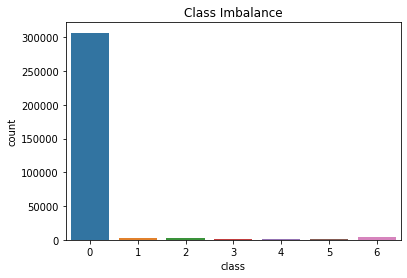

In [212]:
ax = sns.countplot(x="class", data=all_comdata_df).set_title('Class Imbalance')


In [ ]:
def createGraphs(df, title):
  """ Given a dataframe, creates 2 graphs: 
      Histogram of word counts
      Bar graph of top 10 subreddits """
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18.5, 10.5)
  fig.suptitle(title)
  df.hist(column='word_count', ax=ax1)
  ax1.set_title('Word Count')
  ax1.set_xlabel('Word Count')
  ax1.set_ylabel('Frequency')

  #Subreddits
  df_dict = df['subreddit'].value_counts()
  df_dict = df_dict.to_dict()
  df_dict = dict(sorted(df_dict.items(), key=lambda x: x[1], reverse=True))
  keys = list(df_dict.keys())
  values = list(df_dict.values())

  ax2.bar(keys[:10], values[:10], color='#6600CC')
  #plt.bar(keys[:10], values[:10], ax=ax2, color='#6600CC')
  ax2.set_title('Top 10 Subreddits')
  ax2.set_xlabel('Subreddits')
  plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
  ax2.set_ylabel('Count')

    

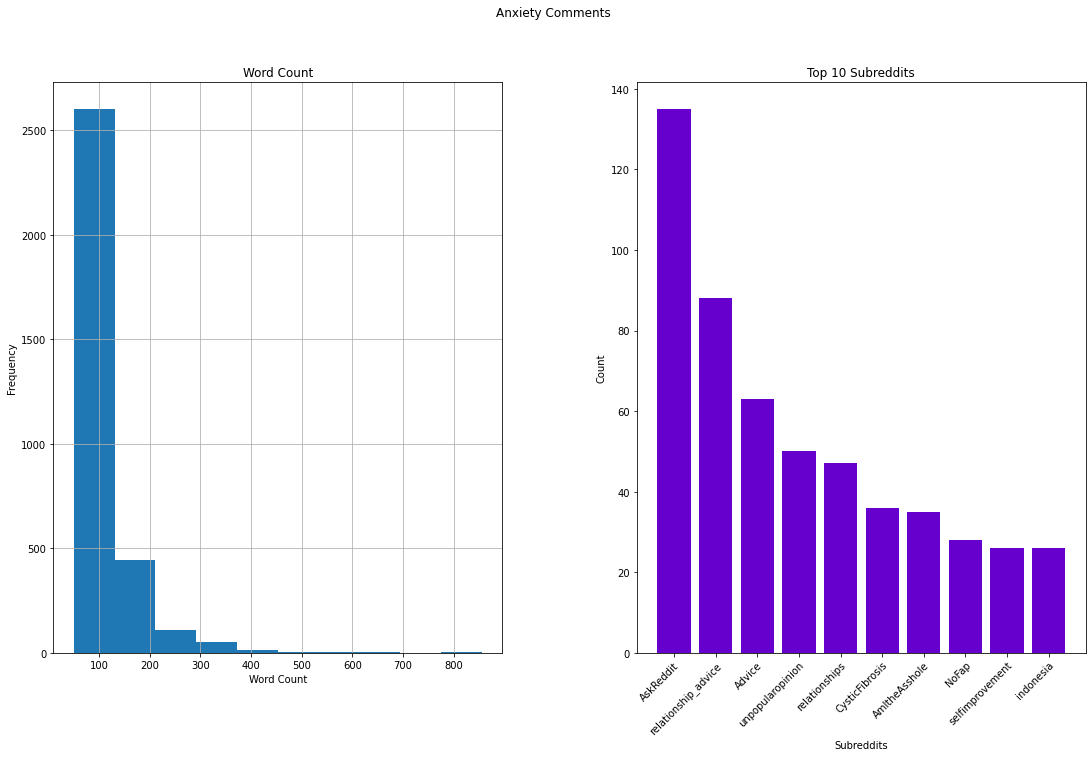

In [ ]:
createGraphs(anxiety_coms_df_shortened, 'Anxiety Comments')

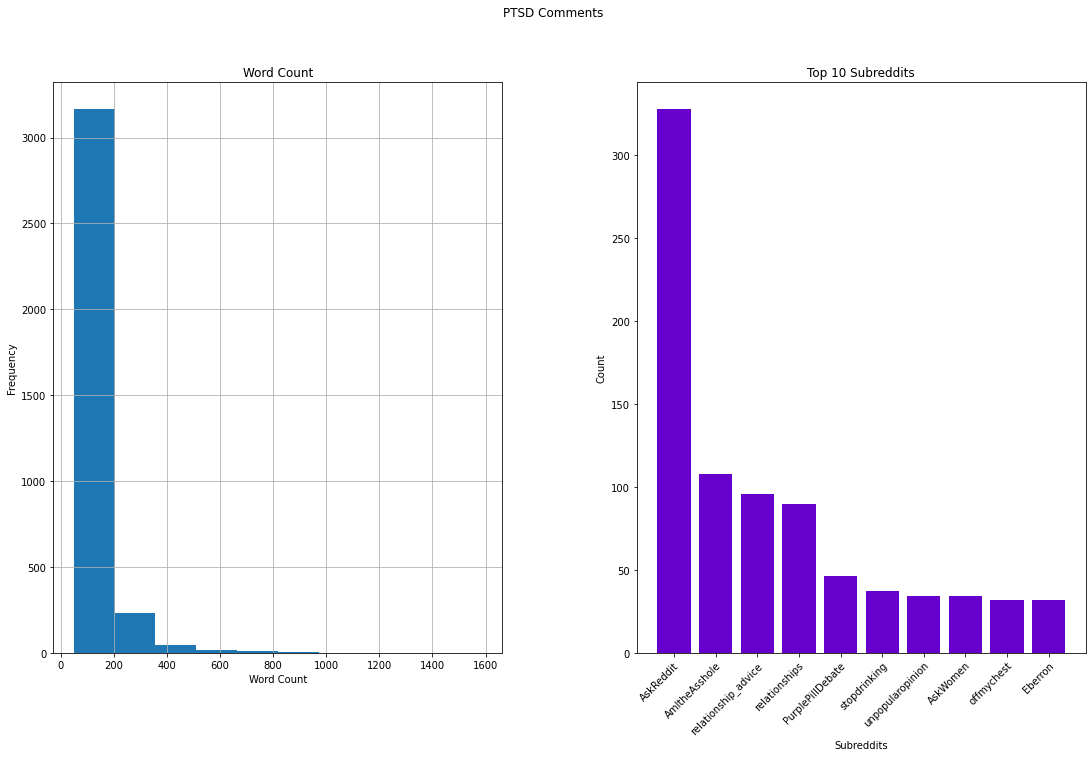

In [ ]:
createGraphs(ptsd_coms_df_shortened, 'PTSD Comments')

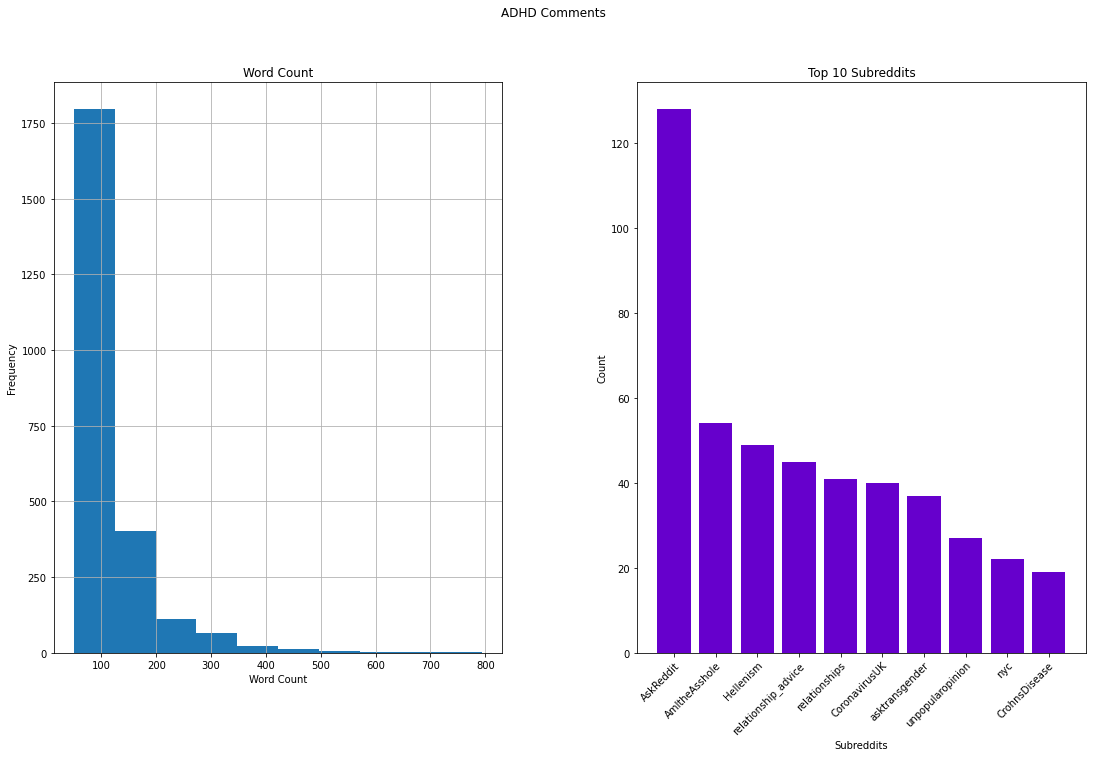

In [ ]:
createGraphs(adhd_coms_df_shortened, 'ADHD Comments')

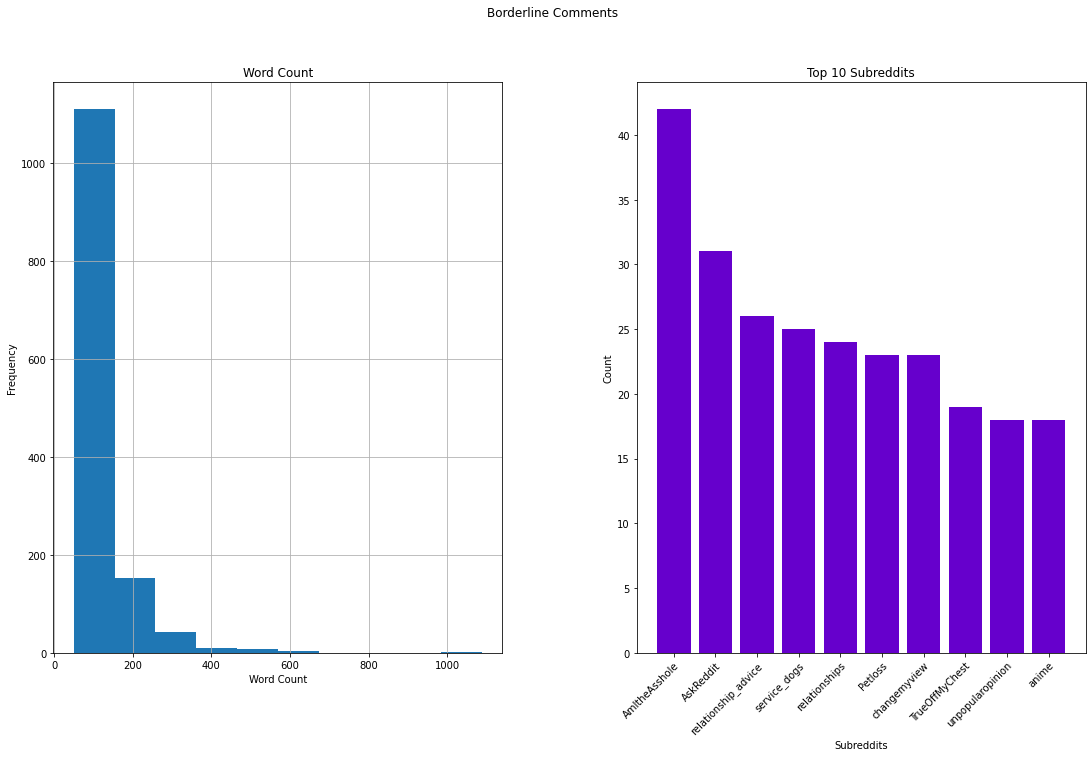

In [ ]:
createGraphs(bpd_coms_df_shortened, 'Borderline Comments')

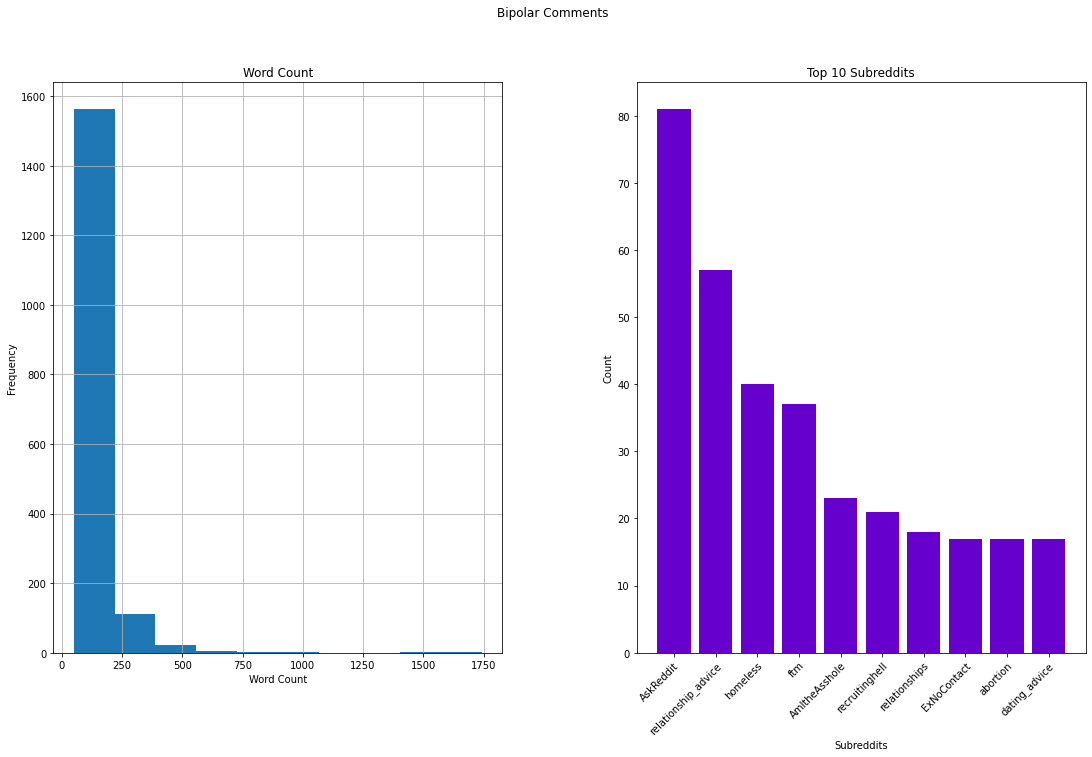

In [ ]:
createGraphs(bipolar_coms_df_shortened, 'Bipolar Comments')

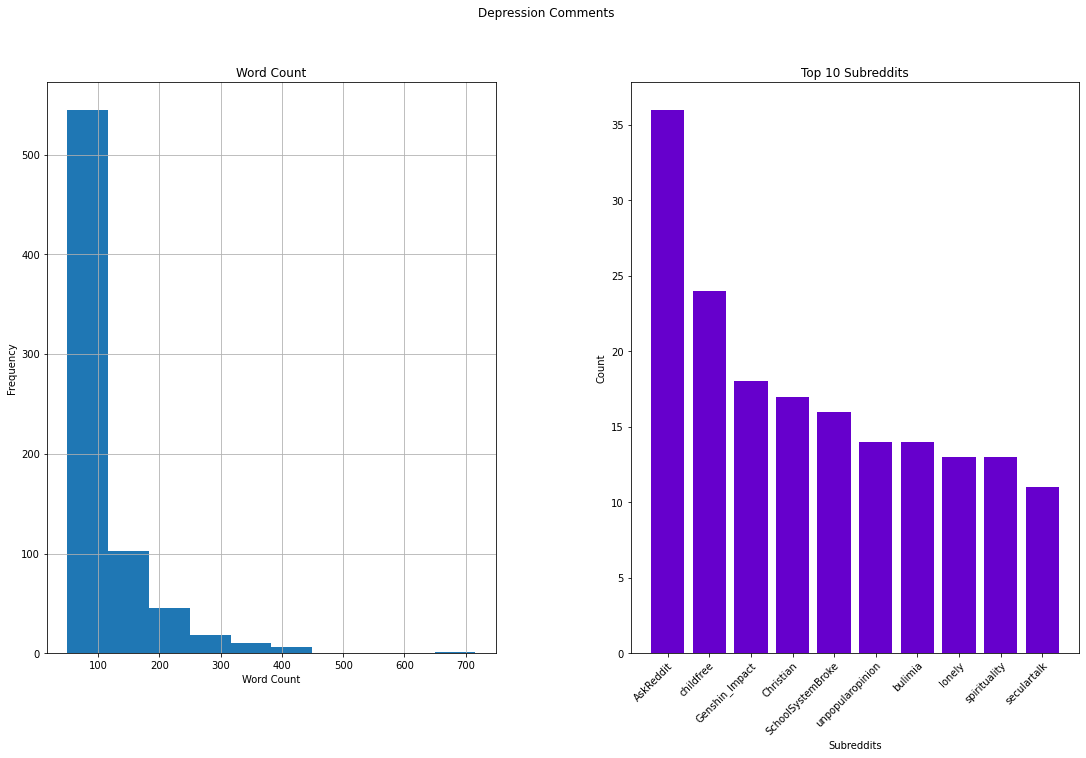

In [ ]:
createGraphs(dep_coms_df_shortened, 'Depression Comments')

## Preprocessing the Data

I create helper functions and a class to preprocess data in various ways for analysis.  The preprocess_text function prepares data for either Word2Vec models (sentences) or other encoding. 

In [200]:
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

In [201]:
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode(text)
    return text

In [202]:
def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

In [203]:
stopwords_list = stopwords.words('english')
stopwords_list += ["''", '""', '...', '``']
stopwords_list.remove('against')
stopwords_list.remove('not')

In [204]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [205]:
def preprocess_data(text, stem=True, word2vec=True):
  """ takes in a string and returns it processed: removes HTML tags, accented characters
  expands contractions, lowercases the words, removes extra spaces and new lines, 
  removes punctuation, removes numbers, and tokenizes it """

  #remove HTML tags
  preprocessed_text = strip_html_tags(text)

  #remove accented characters
  preprocessed_text = remove_accented_chars(preprocessed_text)

  #expand contractions
  preprocessed_text = expand_contractions(preprocessed_text)

  #lowercase the words
  preprocessed_text = preprocessed_text.lower()

  #delete preceding spaces
  preprocessed_text = preprocessed_text.strip()

  #normalize spaces to 1
  preprocessed_text = re.sub(" +", " ", preprocessed_text)

  #remove trailing whitespace
  preprocessed_text = preprocessed_text.rstrip()

  #remove \n \t
  preprocessed_text = preprocessed_text.replace("\n", " ").replace('\t', ' ')


  if word2vec:
    #remove all characters except A-Z and period
    preprocessed_text = re.sub("[^a-zA-Z\.]", " ", preprocessed_text)
    #get sentences from the tokenizer and the remove the period
    preprocessed_text = sentence_tokenizer.tokenize(preprocessed_text)
    preprocessed_text = [re.sub("[\.]", "", sentence) for sentence in preprocessed_text]
  else: 
     #remove all characters except A-Z 
     preprocessed_text = re.sub(r'[^a-zA-Z]', ' ', preprocessed_text)
     #tokenize it 
     preprocessed_text = nltk.word_tokenize(preprocessed_text)
     



  #remove stopwords
  preprocessed_text = [word for word in preprocessed_text if word not in stopwords_list]

  if stem:
    #stem words
    ps = PorterStemmer()
    preprocessed_text = [ps.stem(word) for word in preprocessed_text]

  return preprocessed_text

In [206]:
class W2vVectorizer(object):
    #mean embedding vectorizer class 
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v] 
                   or [np.zeros(self.dimensions)], axis=0) for words in X])



In [207]:
def use_word2vec(data, size=100, window_size=5, min_count=5, workers=4, epochs=10, sg=0):
  """ creates Word2Vec model based on paramters entered, and returns the model
  and word vectors
    Paramaters:
      data: The dataset we'll be training on
      size: defaults to 100, the size of the word vectors to create
      window_size: defaults to 5, the window size
      min_count: defaults to 5, minimum number of times a word needs to appear in order to be counted in the model
      workers: defaults to 4, number of threads to use during training
      epochs: defaults to 10, number of epochs you want to train for
  
   """
  model = word2vec.Word2Vec(data, size=size, window=window_size, min_count=min_count, workers=workers, sg=sg)

  #train the model
  model.train(data, total_examples=model.corpus_count, epochs=epochs)

  #save the word vectors
  wv = model.wv

  return model, wv


## Data Preparation 

For the comments and submissions combined dataframe (all_df), I create a new column that combines the text entries, as they were under different columns in different dataframes.  This dataframe isn't analyzed until the end, as I try to build models off of comment data alone first. 

I create 2 columns, one with data preprocessed for Word2Vec, and one that is tokenized and stemmed for other embedding. 

In [208]:
#all_df is the dataframe containing both submission and comment data, and isn't used until the end
#creates one column that has the text for each entry (as it was named different things in different dataframes)
all_df['text'] = all_df['body'].fillna('') + all_df['selftex'].fillna('') + all_df['selftext'].fillna('')

In [209]:
#creates a column processed for the word2vec model 
all_comdata_df['tokenized_word2vec'] = [preprocess_data(x, stem=False) for x in all_comdata_df['body']]

In [210]:
#creates a column processed for other embedding
all_comdata_df['tokenized_stemmed'] = [preprocess_data(x, stem=True, word2vec=False) for x in all_comdata_df['body']]

In [ ]:
all_comdata_df['tokenized_stemmed'][1]

['learn',
 'read',
 'interpret',
 'word',
 'first',
 'said',
 'pretti',
 'sure',
 'resid',
 'pharmacist',
 'recommend',
 'certain',
 'medic',
 'would',
 'benefit',
 'patient',
 'deem',
 'prescrib',
 'prescript',
 'inadequ',
 'knowledg',
 'drug',
 'interact',
 'well',
 'method',
 'drug',
 'therapi',
 'nitpick',
 'part',
 'post',
 'not',
 'make',
 'smart',
 'dickhead']

## Train Test Split

There are over 300,000 data points for users without a mental health classification in the comment data, and only 12,873 data points for those with any sort of mental health classification.  In order to start addressing this class balance, I undersample from the majority class, randomly sampling 50,000 users. 

I then split the data into training and testing sets, stratifying the data to continue addressing the imbalance. 

In [213]:
#add a column that classifies the data into those struggling with mental health and the neutral data
all_comdata_df['class_bin'] = [y if y == 0 else 1 for y in all_comdata_df['class']]

In [214]:
all_comdata_df['class_bin'].value_counts()

0    306815
1     12873
Name: class_bin, dtype: int64

In [215]:
#create dataframe without unnecessary columns 
com_df_for_models = all_comdata_df[['tokenized_word2vec', 'tokenized_stemmed', 'class', 'class_bin']]

In [216]:
#undersample from the neutral class since it's so much bigger.
#undersampled is the indexes for the randomly selected rows. 
#I then combine it with the other entries  
undersampled = com_df_for_models[com_df_for_models['class_bin'] == 0].sample(50000).index
non_neutral_indices = com_df_for_models[com_df_for_models['class_bin'] ==1].index
com_df_for_models = com_df_for_models.loc[undersampled.union(non_neutral_indices)]

In [217]:
#tran test split
X = com_df_for_models[['tokenized_word2vec', 'tokenized_stemmed']]
y = com_df_for_models['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.20, random_state=42)

In [218]:
y_train.value_counts()

0    40000
6     2779
1     2586
2     1936
3     1367
4     1059
5      571
Name: class, dtype: int64

## Model 1: Word2Vec with Random Forest

I train a word2vec model using gensim and obtain word embeddings from it.  I then use those embeddings with a Random Forest Classifier. 

In [ ]:
X_train['tokenized_word2vec']

70900     [yup, it is how it goes, for the most part  yo...
55252     [are you keeping the polish on the nail  some ...
214189    [hun you need to see a counsellor for strength...
199464    [nope  she needed to know, nta, this let us he...
225250    [i do not know the name  and would not utter i...
                                ...                        
173720    [they seem to plan for what is best for most p...
278339    [from what i remember  water quality gets wors...
171130    [usa today had their own judges experts or who...
266601    [i have not, the closest i have been to colora...
211089    [neither   there is a lot of debate in the fie...
Name: tokenized_word2vec, Length: 255750, dtype: object

In [ ]:
y.value_counts()

0    306826
6      3474
1      3233
2      2420
3      1709
4      1328
5       728
Name: class, dtype: int64

In [219]:
#w2vmodel is the word2vec model, wv is the wordvectors 
w2vmodel, wv = use_word2vec(X_train['tokenized_word2vec'])

In [220]:
#turn it into a dictionary to pass it into the W2vVectorizer
wv_dict = dict(zip(wv.index2word, wv.syn0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


### Random Forest Classifier Model
First I create a base model using the default parameters. 

In [ ]:
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(wv_dict)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])

In [ ]:
score = cross_val_score(rf, X_train['tokenized_word2vec'], y_train, cv=2, n_jobs=-1).mean()

In [ ]:
score

0.7937094914310708

In [ ]:
rf.fit(X_train['tokenized_word2vec'], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.3s finished


Pipeline(memory=None,
         steps=[('Word2Vec Vectorizer',
                 <__main__.W2vVectorizer object at 0x7f2370aa2d10>),
                ('Random Forest',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=True, warm_start=False))],
         verbose=False)

In [ ]:
y_pred_test = rf.predict(X_test['tokenized_word2vec'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     10000
           1       0.75      0.00      0.01       647
           2       0.00      0.00      0.00       484
           3       0.00      0.00      0.00       342
           4       0.00      0.00      0.00       264
           5       0.00      0.00      0.00       143
           6       0.36      0.01      0.01       695

    accuracy                           0.80     12575
   macro avg       0.27      0.14      0.13     12575
weighted avg       0.69      0.80      0.71     12575



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model ignores most entries not in the majority class when trained with the default paramaters.  To try to address this class imbalance, my next model runs a gridsearch looking at max features, max depth, min samples split, and min samples leaf. It uses f1_macro to decide which paramaters are best. F1 score helps select a model with a balance between precision and recall scores. Macro F1-score treats all classes the same, regardless of how many entries are in each.  This score will be low for models that are only able to perform well on common classes. 


In [ ]:
rf2pipeline =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(wv_dict)),
              ('rf_classifier', RandomForestClassifier(verbose=True))])

In [ ]:
max_features = ['auto', 'sqrt', 'log2']
max_depth = [10, 20, 30]
min_samples_split = [2, 5, 12]
min_samples_leaf = [1, 2, 5, 10]

rf_grid_param = {'rf_classifier__max_depth': max_depth,
                 'rf_classifier__min_samples_split': min_samples_split,
                 'rf_classifier__max_features': max_features,
                 'rf_classifier__min_samples_leaf': min_samples_leaf}

In [ ]:
rf_grid_pipeline = GridSearchCV(rf2pipeline, rf_grid_param, n_jobs=-1, scoring='f1_macro')

In [ ]:
rf_grid_pipeline.fit(X_train['tokenized_word2vec'],y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.9s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Word2Vec Vectorizer',
                                        <__main__.W2vVectorizer object at 0x7f237096f510>),
                                       ('rf_classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                        

In [ ]:
rf_grid_pipeline.best_params_, rf_grid_pipeline.best_score_, 

({'rf_classifier__max_depth': 30,
  'rf_classifier__max_features': 'auto',
  'rf_classifier__min_samples_leaf': 1,
  'rf_classifier__min_samples_split': 2},
 0.13082237174324718)

In [ ]:
y_pred_test = rf_grid_pipeline.predict(X_test['tokenized_word2vec'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
gridsearch1 = classification_report(y_test, y_pred_test, output_dict=True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'f1-score': 0.8861309339125037,
  'precision': 0.7957965130164796,
  'recall': 0.9996,
  'support': 10000},
 '1': {'f1-score': 0.00923076923076923,
  'precision': 1.0,
  'recall': 0.00463678516228748,
  'support': 647},
 '2': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 484},
 '3': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 342},
 '4': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 264},
 '5': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 143},
 '6': {'f1-score': 0.011379800853485063,
  'precision': 0.5,
  'recall': 0.0057553956834532375,
  'support': 695},
 'accuracy': 0.7954671968190855,
 'macro avg': {'f1-score': 0.12953450057096544,
  'precision': 0.3279709304309257,
  'recall': 0.14428459726367726,
  'support': 12575},
 'weighted avg': {'f1-score': 0.7057805652811543,
  'precision': 0.7119256564743376,
  'recall': 0.7954671968190855,
  'support': 12575}}

This model also performed poorly, as even evaluating the paramaters based on f1_macro score, the model ignores less common classes.

To address this, I create one more random forest classifier that applies weights inversely proportional to class frequencies. 

In [221]:
rf2pipeline2 =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(wv_dict)),
              ('rf_classifier', RandomForestClassifier(class_weight='balanced',n_jobs=-1, verbose=True))])

In [222]:
#parameters for the grid search 

max_features = ['auto', 'sqrt', 'log2']
max_depth = [10, 20, 30, 40]
min_samples_split = [2, 5, 12]
min_samples_leaf = [1, 2, 5, 10]

rf_grid_param = {'rf_classifier__max_depth': max_depth,
                 'rf_classifier__min_samples_split': min_samples_split,
                 'rf_classifier__max_features': max_features,
                 'rf_classifier__min_samples_leaf': min_samples_leaf}

In [223]:
#run the gridsearch, keeping the parameter values that give the best f1_macro score 
rf_grid_pipeline2 = GridSearchCV(rf2pipeline2, rf_grid_param, n_jobs=-1, scoring='f1_macro')

In [224]:
rf_grid_pipeline2.fit(X_train['tokenized_word2vec'],y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Word2Vec Vectorizer',
                                        <__main__.W2vVectorizer object at 0x7ff8c9a5ff10>),
                                       ('rf_classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight='balanced',
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                  

In [225]:
rf_grid_pipeline2.best_params_, rf_grid_pipeline2.best_score_, 

({'rf_classifier__max_depth': 10,
  'rf_classifier__max_features': 'auto',
  'rf_classifier__min_samples_leaf': 5,
  'rf_classifier__min_samples_split': 5},
 0.03729379947789506)

In [226]:
y_pred_test = rf_grid_pipeline2.predict(X_test['tokenized_word2vec'])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [250]:
cfn = confusion_matrix(y_test, y_pred_test)

In [249]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    code from: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
    """
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 347   38  115   74   78 9252   96]
 [  21    8    6    4    4  592   12]
 [   7    4    5    4    6  454    4]
 [   7    4    7    5    5  311    3]
 [   3    0    2    4    2  249    4]
 [   2    0    1    1    3  134    2]
 [  15    6   11   10    7  631   15]]


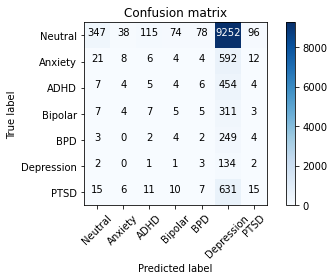

In [252]:
plot_confusion_matrix(cfn, classes=['Neutral', 'Anxiety', 'ADHD', 'Bipolar', 'BPD', 'Depression', 'PTSD'],
                      title='Confusion matrix')

In [227]:
gridsearch2 = classification_report(y_test, y_pred_test, output_dict=True)

In [229]:
gridsearch2['anxiety'] = gridsearch2.pop('1')
gridsearch2['adhd'] = gridsearch2.pop('2')
gridsearch2['bipolar'] = gridsearch2.pop('3')
gridsearch2['bpd'] = gridsearch2.pop('4')
gridsearch2['depression'] = gridsearch2.pop('5')
gridsearch2['ptsd'] = gridsearch2.pop('6')
gridsearch2['neutral'] = gridsearch2.pop('0')

In [230]:
pprint.pprint(gridsearch2)

{'accuracy': 0.0410337972166998,
 'adhd': {'f1-score': 0.01584786053882726,
          'precision': 0.034013605442176874,
          'recall': 0.010330578512396695,
          'support': 484},
 'anxiety': {'f1-score': 0.02263083451202263,
             'precision': 0.13333333333333333,
             'recall': 0.012364760432766615,
             'support': 647},
 'bipolar': {'f1-score': 0.022522522522522525,
             'precision': 0.049019607843137254,
             'recall': 0.014619883040935672,
             'support': 342},
 'bpd': {'f1-score': 0.010840108401084013,
         'precision': 0.01904761904761905,
         'recall': 0.007575757575757576,
         'support': 264},
 'depression': {'f1-score': 0.022777494475607687,
                'precision': 0.011528865181106428,
                'recall': 0.9370629370629371,
                'support': 143},
 'macro avg': {'f1-score': 0.028205406048638144,
               'precision': 0.17434588972806028,
               'recall': 0.14831952149110

This model performs better, though still not well. It does not ignore the smaller classes. Interestingly, anxiety has a precision of 13%, even though recall is only 1%.  Depression only has a precision of 1% but has a recall score of 93.7%, meaning the model tries to guess it often, but usually is wrong.  PTSD has a precision of 11% and a recall of 2%.




## Model 2: LSTM 

I create encodings for the 50,000 most common words in the comment data, and train them using Keras LSTM. I do this because the vocabulary is very large, with numerous strange "words" that are only used once.  I then try to classify indviduals as neutral (not-diagnosed), or in one of the 6 diagnoses.  This model also does not perform well, likely because I chose poorly for the hidden dimension sizes. It completely ignores several classes and does not atempt to predict them.  


In [231]:
def check_encoding(word, token_map):
  """ This function checks if encoding exists for a word. 

  Parameters:
  word (string): word to check
  token_map (set): mapping of words to their numerical representation

  Returns:
  int: encoding if it exists, 0 if it does not 

  """
  if word in token_map:
    return token_map.get(word)
  else: 
    return 0

In [232]:
#calculates the frequency of each word
word_freq = Counter()
for entry in X_train['tokenized_stemmed']:
  word_freq.update(entry)

In [233]:
word_freq.most_common(20)

[('not', 95725),
 ('like', 29419),
 ('would', 25106),
 ('get', 24526),
 ('peopl', 19464),
 ('go', 17815),
 ('one', 16473),
 ('time', 15662),
 ('think', 15655),
 ('want', 14750),
 ('make', 14589),
 ('know', 13731),
 ('thing', 12912),
 ('feel', 11544),
 ('even', 11343),
 ('also', 11284),
 ('realli', 11136),
 ('say', 10644),
 ('work', 10597),
 ('need', 10372)]

In [ ]:
word_freq.most_common()[:-5:-1]

[('bkund', 1), ('enviroment', 1), ('reqd', 1), ('odiou', 1)]

In [234]:
#I narrow down the vocabulary to 50,000 words to get rid of words that appear very few times. 
final_word = word_freq.most_common(50000) #list of tuples of word and frequency 

In [95]:
final_word[0:10] 

[('not', 72228),
 ('like', 21997),
 ('would', 18856),
 ('get', 17984),
 ('peopl', 14832),
 ('go', 13419),
 ('one', 12384),
 ('time', 11943),
 ('think', 11836),
 ('want', 11012)]

In [235]:
final_word_dict = dict(final_word)

In [236]:
#this is the list of vocabulary words the model will use 
vocab = final_word_dict.keys()

In [237]:
#I create a dictionary mapping each word to a number representing it 
token_map = {word: i+1 for i, word in enumerate(vocab)} #offset by 1 to allow for padding value
token_map['<#PAD>'] = 0


In [238]:
#create our sentences out of numbers 
X_train_indices = [[check_encoding(word, token_map) for word in sent] for sent in X_train['tokenized_stemmed']]

#use the encoding on the test data
X_test_indices = [[check_encoding(word, token_map) for word in sent] for sent in X_test['tokenized_stemmed']]


In [284]:
def eval_metric(model, history, metric_name, ep=7):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    code from: https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e

    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, ep + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

In [240]:
#pad the sentences so they're the same length 
X_train_indices = tf.keras.preprocessing.sequence.pad_sequences(X_train_indices, padding='post').tolist()
X_test_indices = tf.keras.preprocessing.sequence.pad_sequences(X_test_indices, padding = 'post').tolist()

In [144]:
#building a LSTM model. Creating an embedding layer with indices to vectors

dim = 128
hid_dim = 64

model_lstm = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(len(vocab)+1, dim, embeddings_initializer='orthogonal', mask_zero=True), #+1 because of padding index
                                    tf.keras.layers.LSTM(hid_dim, return_sequences=False), 
                                    tf.keras.layers.Dense(7, activation=tf.nn.leaky_relu), 
                                    tf.keras.layers.Softmax()
])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         6400128   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
_________________________________________________________________
softmax_3 (Softmax)          (None, 7)                 0         
Total params: 6,449,991
Trainable params: 6,449,991
Non-trainable params: 0
_________________________________________________________________


In [84]:
def recall(y_true, y_pred):
  """calculates recall for multiclass.  Code from: https://neptune.ai/blog/keras-metrics"""
  y_true = K.ones_like(y_true) 
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
  recall = true_positives / (all_positives + K.epsilon())
  return recall

In [145]:
model_lstm.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy(),
                       recall]) 
callback = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2),
            tf.keras.callbacks.ModelCheckpoint(filepath='{epoch:02d}.hdf5')]

In [136]:

history = model_lstm.fit(x=np.array(X_train_indices), y=y_train, validation_split=.2,
                         workers=-1,
                         epochs=7, callbacks=callback)

Epoch 1/7
1258/1258 [==============================] - 2316s 2s/step - loss: 0.8594 - sparse_categorical_accuracy: 0.7931 - recall: 0.9831 - val_loss: 0.8230 - val_sparse_categorical_accuracy: 0.7941 - val_recall: 0.9938
Epoch 2/7
1258/1258 [==============================] - 2337s 2s/step - loss: 0.7750 - sparse_categorical_accuracy: 0.7940 - recall: 0.9407 - val_loss: 0.8360 - val_sparse_categorical_accuracy: 0.7949 - val_recall: 0.9745
Epoch 3/7
1258/1258 [==============================] - 2321s 2s/step - loss: 0.6484 - sparse_categorical_accuracy: 0.7973 - recall: 0.8647 - val_loss: 0.8841 - val_sparse_categorical_accuracy: 0.7985 - val_recall: 0.8899
Epoch 4/7
1258/1258 [==============================] - 2268s 2s/step - loss: 0.4872 - sparse_categorical_accuracy: 0.8040 - recall: 0.8719 - val_loss: 0.9768 - val_sparse_categorical_accuracy: 0.8076 - val_recall: 0.8946
Epoch 5/7
1258/1258 [==============================] - 2266s 2s/step - loss: 0.3329 - sparse_categorical_accuracy: 0

In [137]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'recall', 'val_loss', 'val_sparse_categorical_accuracy', 'val_recall'])


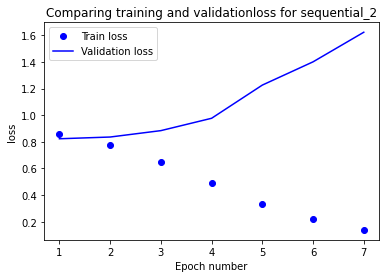

In [138]:
eval_metric(model_lstm, history, 'loss')

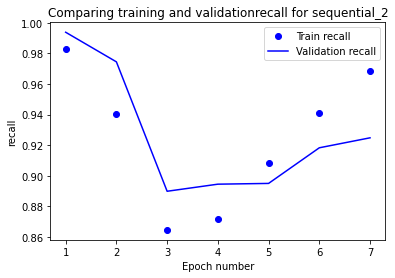

In [139]:
eval_metric(model_lstm, history, 'recall')

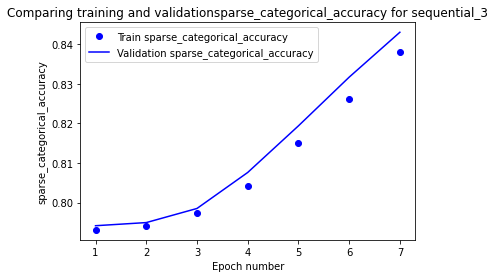

In [149]:
eval_metric(model_lstm, history, 'sparse_categorical_accuracy')

The graphs show that the model begins to overfit after the first training epoch as validation loss increases. I build the model again and only train it for one epoch. 

In [146]:

dim = 128
hid_dim = 64

model_lstm_epoch2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(len(vocab)+1, dim, embeddings_initializer='orthogonal', mask_zero=True), #+1 because of padding index
                                    tf.keras.layers.LSTM(hid_dim, return_sequences=False), 
                                    tf.keras.layers.Dense(7, activation=tf.nn.leaky_relu), 
                                    tf.keras.layers.Softmax()
])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         6400128   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
_________________________________________________________________
softmax_3 (Softmax)          (None, 7)                 0         
Total params: 6,449,991
Trainable params: 6,449,991
Non-trainable params: 0
_________________________________________________________________


In [147]:
model_lstm_epoch2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy(),
                       recall]) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [151]:
history = model_lstm_epoch2.fit(x=np.array(X_train_indices), y=y_train, validation_split=.2,
                         workers=-1, callbacks=callback)

1258/1258 [==============================] - 2312s 2s/step - loss: 0.8577 - sparse_categorical_accuracy: 0.7884 - recall: 0.9827 - val_loss: 0.8215 - val_sparse_categorical_accuracy: 0.7942 - val_recall: 0.9996


In [152]:

score = model_lstm_epoch2.evaluate(x=np.array(X_test_indices), y=y_test, verbose = 1)
score_train = model_lstm_epoch2.evaluate(x=np.array(X_train_indices), y=y_train, verbose = 1)

print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')


1572/1572 [==============================] - 223s 142ms/step - loss: 0.7944 - sparse_categorical_accuracy: 0.7948 - recall: 0.9988
Evaluate on test data
Test loss: 0.8248648047447205 / Test accuracy: 0.7950572371482849
Evaluate on train data
Train loss: 0.7944040298461914 / Train accuracy: 0.7948065400123596


In [154]:
model_lstm_epoch2.save('model_lstm_undersampled2')

INFO:tensorflow:Assets written to: model_lstm_undersampled2/assets


INFO:tensorflow:Assets written to: model_lstm_undersampled2/assets


In [155]:
X_test_indices_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_indices, padding = 'post').tolist()
y_pred1 = model_lstm_epoch2.predict(X_test_indices_padded)
y_pred = np.argmax(y_pred1, axis=1).astype(int)

lstm = classification_report(y_test, y_pred, output_dict=True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [157]:
lstm.keys()   classes = {'anxiety': 1, 'adhd': 2, 'bipolar': 3, 'bpd': 4, 'depression': 5, 'ptsd': 6, 'control': 0}

dict_keys(['0', '1', '2', '3', '4', '5', '6', 'accuracy', 'macro avg', 'weighted avg'])

In [158]:
lstm['anxiety'] = lstm.pop('1')
lstm['adhd'] = lstm.pop('2')
lstm['bipolar'] = lstm.pop('3')
lstm['bpd'] = lstm.pop('4')
lstm['depression'] = lstm.pop('5')
lstm['ptsd'] = lstm.pop('6')
lstm['neutral'] = lstm.pop('0')


In [161]:
pprint.pprint(lstm)

{'accuracy': 0.7952286282306164,
 'adhd': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 484},
 'anxiety': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 647},
 'bipolar': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 342},
 'bpd': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 264},
 'depression': {'f1-score': 0.0,
                'precision': 0.0,
                'recall': 0.0,
                'support': 143},
 'macro avg': {'f1-score': 0.1265622528081,
               'precision': 0.11360408974723091,
               'recall': 0.14285714285714285,
               'support': 12575},
 'neutral': {'f1-score': 0.8859357696567,
             'precision': 0.7952286282306164,
             'recall': 1.0,
             'support': 10000},
 'ptsd': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 695},
 'weighted avg': {'f1-score': 0.7045214868045327,
                  'precision': 0.6323885711575478,
                  'recal

Confusion matrix, without normalization
[[10000     0     0     0     0     0     0]
 [  647     0     0     0     0     0     0]
 [  484     0     0     0     0     0     0]
 [  342     0     0     0     0     0     0]
 [  264     0     0     0     0     0     0]
 [  143     0     0     0     0     0     0]
 [  695     0     0     0     0     0     0]]


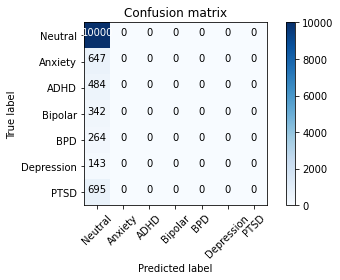

In [262]:
cfn = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cfn, classes=['Neutral', 'Anxiety', 'ADHD', 'Bipolar', 'BPD', 'Depression', 'PTSD'],
                      title='Confusion matrix')

This model doesn't perform well as it ignores the smaller classes. I use 'balanced' class weights to make up for the class imbalance in the next model.  

In [279]:
#building a LSTM model. Creating an embeddg layer with indices to vectors

dim = 128
hid_dim = 64

model_lstm_cw = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(len(vocab)+1, dim, embeddings_initializer='orthogonal', mask_zero=True), #+1 because of padding index
                                    tf.keras.layers.LSTM(hid_dim, return_sequences=False), 
                                    tf.keras.layers.Dense(7, activation=tf.nn.leaky_relu), 
                                    tf.keras.layers.Softmax()
])
model_lstm_cw.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         6400128   
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 455       
_________________________________________________________________
softmax_7 (Softmax)          (None, 7)                 0         
Total params: 6,449,991
Trainable params: 6,449,991
Non-trainable params: 0
_________________________________________________________________


In [280]:
model_lstm_cw.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy(),
                       recall]) 
callback = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2),
            tf.keras.callbacks.ModelCheckpoint(filepath='{epoch:02d}.hdf5')]



In [274]:
unique = np.unique(y_train)
class_weights = class_weight.compute_class_weight('balanced', unique, y_train)
class_weight_dict = dict(enumerate(class_weights))

In [275]:
class_weight_dict

{0: 0.1796357142857143,
 1: 2.7785880013258204,
 2: 3.7114817001180636,
 3: 5.256348625770718,
 4: 6.7851072440307565,
 5: 12.5839379534651,
 6: 2.585616614403948}

In [281]:
history2 = model_lstm_cw.fit(x=np.array(X_train_indices), y=y_train, validation_split=.2,
                          class_weight=class_weight_dict, workers=-1, epochs=2, callbacks=callback)

Epoch 1/2
1258/1258 [==============================] - 2584s 2s/step - loss: 1.9382 - sparse_categorical_accuracy: 0.3259 - recall: 6.9555e-04 - val_loss: 1.8356 - val_sparse_categorical_accuracy: 0.3401 - val_recall: 0.0017
Epoch 2/2
1258/1258 [==============================] - 2572s 2s/step - loss: 1.7472 - sparse_categorical_accuracy: 0.3552 - recall: 0.1160 - val_loss: 1.8402 - val_sparse_categorical_accuracy: 0.3505 - val_recall: 0.0878


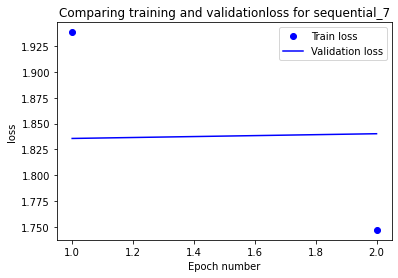

In [285]:
eval_metric(model_lstm_cw, history2, 'loss', ep=2)

In [286]:

score = model_lstm_cw.evaluate(x=np.array(X_test_indices), y=y_test, verbose = 1)
score_train = model_lstm_cw.evaluate(x=np.array(X_train_indices), y=y_train, verbose = 1)

print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')

1572/1572 [==============================] - 130s 83ms/step - loss: 1.6482 - sparse_categorical_accuracy: 0.3463 - recall: 0.1273
Evaluate on test data
Test loss: 1.8310335874557495 / Test accuracy: 0.34027591347694397
Evaluate on train data
Train loss: 1.6482223272323608 / Train accuracy: 0.34629321098327637


In [288]:
y_pred1 = model_lstm_cw.predict(X_test_indices_padded)
y_pred = np.argmax(y_pred1, axis=1).astype(int)

lstm_cw = classification_report(y_test, y_pred, output_dict=True)

In [289]:
lstm_cw['anxiety'] = lstm_cw.pop('1')
lstm_cw['adhd'] = lstm_cw.pop('2')
lstm_cw['bipolar'] = lstm_cw.pop('3')
lstm_cw['bpd'] = lstm_cw.pop('4')
lstm_cw['depression'] = lstm_cw.pop('5')
lstm_cw['ptsd'] = lstm_cw.pop('6')
lstm_cw['neutral'] = lstm_cw.pop('0')

In [290]:
pprint.pprint(lstm_cw)

{'accuracy': 0.22823061630218688,
 'adhd': {'f1-score': 0.07014333638304361,
          'precision': 0.04114490161001789,
          'recall': 0.23760330578512398,
          'support': 484},
 'anxiety': {'f1-score': 0.06371329019412644,
             'precision': 0.04698972099853157,
             'recall': 0.09891808346213292,
             'support': 647},
 'bipolar': {'f1-score': 0.036226415094339624,
             'precision': 0.024415055951169887,
             'recall': 0.07017543859649122,
             'support': 342},
 'bpd': {'f1-score': 0.034383954154727794,
         'precision': 0.022988505747126436,
         'recall': 0.06818181818181818,
         'support': 264},
 'depression': {'f1-score': 0.03306797305572566,
                'precision': 0.018120805369127517,
                'recall': 0.1888111888111888,
                'support': 143},
 'macro avg': {'f1-score': 0.10209153064816394,
               'precision': 0.1494418097944056,
               'recall': 0.1580906341647574,
  

Confusion matrix, without normalization
[[2487 1072 2204  785  609 1155 1688]
 [ 111   64  142   54   46  105  125]
 [ 105   45  115   40   33   58   88]
 [  74   35   94   24   16   36   63]
 [  58   39   61   21   18   27   40]
 [  24   16   30    8   11   27   27]
 [ 137   91  149   51   50   82  135]]


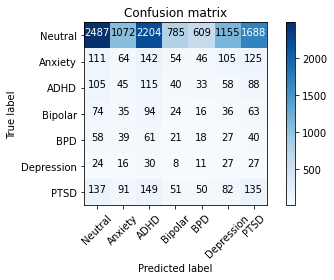

In [291]:
cfn = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cfn, classes=['Neutral', 'Anxiety', 'ADHD', 'Bipolar', 'BPD', 'Depression', 'PTSD'],
                      title='Confusion matrix')

In [292]:
model_lstm_cw.save('model_lstm_cw.h5')


Based on the results of the above model, I only trained this one for 2 epochs. Looking at the graph, it would likely overfit very quickly as well so stopping at 2 epochs was warrented. The model tries to identify each class, but struggles to do so well. The neutral class has a recall of 24.87%, and a precision of 83%. 

ADHD - 23.8% recall, 4% Precision

Anxiety - Recall 9.89%, Precision 5%

Bipolar - Recall 7% Precision 2.4%

BPD - Recall 6.8%, Precision 2.3%

Depression - Recall 18.88%, Precision 1.8%

PTSD - Recall 19.4%, Precision 6.2%


## Strategy Change, and a More Successful Model

I decide that comment data alone is not enough, so I use both the submission and comment data. I also use sbert to increase the accuracy of my word embeddings. In addition, I undersample from the "control" group. Finally, I break the process into 2 different classifications - first a binary classification of whether someone is struggling with their mental health or not, and then for those that are, a second model to classify which mental illness they may be struggling with.  

### Model with all data from non-mental health subreddits
This is my first time using both comment and submission data combined, so I have to do train test split. 


In [293]:
#column classifying the user as either "neutral" or having a mental health classification 
all_df['class_bin'] = [y if y == 0 else 1 for y in all_df['class']]

In [326]:
#I sample 50,000 users from the "neutral" class. I then combine those with the mental health classes to create the model. 
undersampled_all = all_df[all_df['class_bin'] == 0].sample(50000).index
non_neutral_indices = all_df[all_df['class_bin'] ==1].index
all_df_models = all_df.loc[undersampled_all.union(non_neutral_indices)]

In [327]:
X=all_df_models['text']
y=all_df_models['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [328]:
#y_train and y_test for the binary classification 
y_train_bin = [y if y == 0 else 1 for y in y_train]
y_test_bin = [y if y == 0 else 1 for y in y_test]

In [325]:
all_df['class_bin'].value_counts()

0    352137
1     23422
Name: class_bin, dtype: int64

In [329]:
all_df_models['class_bin'].value_counts()

0    50000
1    23422
Name: class_bin, dtype: int64

### Sbert Encodings
I feed the sentences to the sentence transformer in order to get their encodings. 

In [297]:
model_sbert = SentenceTransformer('paraphrase-distilroberta-base-v1')


In [330]:
embeddings2 = model_sbert.encode(X_train.to_list(), show_progress_bar=True)

In [331]:
embeddings2.shape #I use the shape dimension to decide the dimensions for my model 

(58737, 768)

In [332]:
embeddings_test = model_sbert.encode(X_test.to_list(), show_progress_bar=True)

### Binary Classifier
This model is a binary classifer to classify whether entries belong to the neutral class or the mental health class. 

In [333]:
hid_dim1 = 768
hid_dim2 = 384
model_bin_sbert = tf.keras.models.Sequential([
                                             tf.keras.layers.Dense(hid_dim1, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(hid_dim2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(1, activation='sigmoid')
])


In [334]:
model_bin_sbert.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=[tf.keras.metrics.Recall()])

In [335]:
history = model_bin_sbert.fit(x=np.array(embeddings2), y=np.array(y_train_bin), validation_split=.20, workers=-1, epochs=15)


Epoch 1/15
1469/1469 [==============================] - 5s 3ms/step - loss: 0.5480 - recall_2: 0.3378 - val_loss: 0.5349 - val_recall_2: 0.3283
Epoch 2/15
1469/1469 [==============================] - 4s 3ms/step - loss: 0.5215 - recall_2: 0.3965 - val_loss: 0.5237 - val_recall_2: 0.4375
Epoch 3/15
1469/1469 [==============================] - 4s 3ms/step - loss: 0.5061 - recall_2: 0.4203 - val_loss: 0.5206 - val_recall_2: 0.4227
Epoch 4/15
1469/1469 [==============================] - 4s 3ms/step - loss: 0.4915 - recall_2: 0.4420 - val_loss: 0.5312 - val_recall_2: 0.3498
Epoch 5/15
1469/1469 [==============================] - 4s 3ms/step - loss: 0.4741 - recall_2: 0.4685 - val_loss: 0.5266 - val_recall_2: 0.4297
Epoch 6/15
1469/1469 [==============================] - 4s 3ms/step - loss: 0.4534 - recall_2: 0.4954 - val_loss: 0.5276 - val_recall_2: 0.4019
Epoch 7/15
1469/1469 [==============================] - 4s 3ms/step - loss: 0.4285 - recall_2: 0.5317 - val_loss: 0.5579 - val_recall_2:

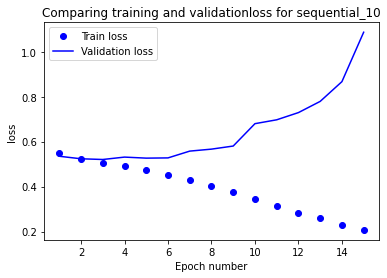

In [336]:
eval_metric(model_bin_sbert, history, 'loss', ep=15)

Based on the loss graph above, the model begins to overfit around the 4th epoch.  I initialize the model again and train it for four epochs.  

In [337]:
hid_dim1 = 768
hid_dim2 = 384
model_bin_sbert_2 = tf.keras.models.Sequential([
                                             tf.keras.layers.Dense(hid_dim1, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(hid_dim2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(1, activation='sigmoid')
])


In [338]:
model_bin_sbert_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=[tf.keras.metrics.Recall()])

In [339]:
history2 = model_bin_sbert_2.fit(x=np.array(embeddings2), y=np.array(y_train_bin), validation_split=.20, workers=-1, epochs=4)


Epoch 1/4
1469/1469 [==============================] - 5s 3ms/step - loss: 0.5485 - recall_3: 0.3009 - val_loss: 0.5376 - val_recall_3: 0.2765
Epoch 2/4
1469/1469 [==============================] - 4s 3ms/step - loss: 0.5242 - recall_3: 0.3454 - val_loss: 0.5282 - val_recall_3: 0.3771
Epoch 3/4
1469/1469 [==============================] - 4s 3ms/step - loss: 0.5102 - recall_3: 0.3636 - val_loss: 0.5173 - val_recall_3: 0.3820
Epoch 4/4
1469/1469 [==============================] - 4s 3ms/step - loss: 0.4972 - recall_3: 0.3913 - val_loss: 0.5257 - val_recall_3: 0.3861


In [340]:
score = model_bin_sbert_2.evaluate(np.array(embeddings_test), np.array(y_test_bin), verbose = 1)
score_train = model_bin_sbert_2.evaluate(np.array(embeddings2), np.array(y_train_bin), verbose = 1)

print()
print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')

#from sklearn.metrics import f1_score, precision_score, recall_score
y_pred1 = model_bin_sbert_2.predict(np.array(embeddings_test))
#y_pred = np.argmax(y_pred1, axis=1)
y_pred = np.round(y_pred1).astype(int)

print((y_pred==1).sum())



print()
print('Precision Score')
print(precision_score(y_test_bin, y_pred, average='macro'))
print()
print('Recall Score')
print(recall_score(y_test_bin, y_pred, average='macro'))
print()
print('F1 Score')
print(f1_score(y_test_bin, y_pred, average='macro'))

1836/1836 [==============================] - 3s 2ms/step - loss: 0.4906 - recall_3: 0.4177

Evaluate on test data
Test loss: 0.5185146927833557 / Test accuracy: 0.3805597722530365
Evaluate on train data
Train loss: 0.4905955493450165 / Train accuracy: 0.417743057012558
2559

Precision Score
0.7249897471624148

Recall Score
0.650333479872776

F1 Score
0.6622736539581376


In [341]:
lstm_cw_2 = classification_report(y_test_bin, y_pred, output_dict=True)


In [342]:
pprint.pprint(lstm_cw_2)

{'0': {'f1-score': 0.8351499864877038,
       'precision': 0.764555500577272,
       'recall': 0.9201071853910282,
       'support': 10076},
 '1': {'f1-score': 0.48939732142857145,
       'precision': 0.6854239937475577,
       'recall': 0.38055977435452376,
       'support': 4609},
 'accuracy': 0.7507660878447395,
 'macro avg': {'f1-score': 0.6622736539581376,
               'precision': 0.7249897471624148,
               'recall': 0.650333479872776,
               'support': 14685},
 'weighted avg': {'f1-score': 0.7266328579036017,
                  'precision': 0.7397194695947624,
                  'recall': 0.7507660878447395,
                  'support': 14685}}


Confusion matrix, without normalization
[[9271  805]
 [2855 1754]]


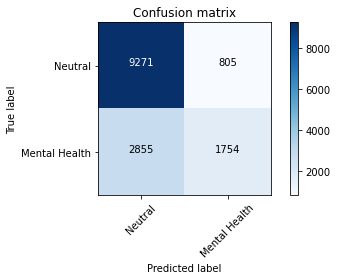

In [343]:
cfn = confusion_matrix(y_test_bin, y_pred)
plot_confusion_matrix(cfn, classes=['Neutral', 'Mental Health'],
                      title='Confusion matrix')

The model has a macro f1-score of 0.66, precision score of .72, and recall of .65.  However, for the mental health class, the f1 score is only .49, precision score of .69, and recall score of .38. Based on this, I create a second version of this model that uses class weights to address the class imbalance. 





In [344]:
hid_dim1 = 768
hid_dim2 = 384
model_bin_sbert_balanced = tf.keras.models.Sequential([
                                             tf.keras.layers.Dense(hid_dim1, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(hid_dim2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(1, activation='sigmoid')
])

In [345]:
model_bin_sbert_balanced.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=[tf.keras.metrics.Recall()])

In [348]:
#calculate the class weights for the model
unique = np.unique(y_train_bin)
class_weights = class_weight.compute_class_weight('balanced', unique, y_train_bin)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.735610159302675, 1: 1.5610747887099345}

In [350]:
history3 = model_bin_sbert_balanced.fit(x=np.array(embeddings2), y=np.array(y_train_bin), validation_split=.20, class_weight=class_weight_dict, workers=-1, epochs=15)


Epoch 1/15
1469/1469 [==============================] - 5s 3ms/step - loss: 0.6041 - recall_4: 0.6909 - val_loss: 0.5867 - val_recall_4: 0.6778
Epoch 2/15
1469/1469 [==============================] - 4s 3ms/step - loss: 0.5767 - recall_4: 0.6602 - val_loss: 0.5483 - val_recall_4: 0.6183
Epoch 3/15
1469/1469 [==============================] - 4s 3ms/step - loss: 0.5605 - recall_4: 0.6703 - val_loss: 0.5765 - val_recall_4: 0.7093
Epoch 4/15
1469/1469 [==============================] - 4s 3ms/step - loss: 0.5449 - recall_4: 0.6869 - val_loss: 0.5556 - val_recall_4: 0.6288
Epoch 5/15
1469/1469 [==============================] - 4s 3ms/step - loss: 0.5277 - recall_4: 0.7003 - val_loss: 0.5572 - val_recall_4: 0.6239
Epoch 6/15
1469/1469 [==============================] - 4s 3ms/step - loss: 0.5045 - recall_4: 0.7221 - val_loss: 0.6342 - val_recall_4: 0.7480
Epoch 7/15
1469/1469 [==============================] - 4s 3ms/step - loss: 0.4777 - recall_4: 0.7453 - val_loss: 0.6095 - val_recall_4:

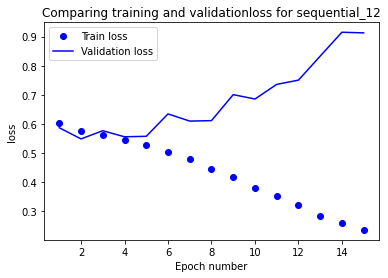

In [351]:
eval_metric(model_bin_sbert_balanced, history3, 'loss', ep=15)

Based on the graph above, the model starts to overfit very quickly, so I only train it for 2 epochs. 

In [352]:
hid_dim1 = 768
hid_dim2 = 384
model_bin_sbert_balanced = tf.keras.models.Sequential([
                                             tf.keras.layers.Dense(hid_dim1, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(hid_dim2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(1, activation='sigmoid')
])

In [353]:
model_bin_sbert_balanced.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=[tf.keras.metrics.Recall()])

In [354]:
history3 = model_bin_sbert_balanced.fit(x=np.array(embeddings2), y=np.array(y_train_bin), validation_split=.20, class_weight=class_weight_dict, workers=-1, epochs=2)


Epoch 1/2
1469/1469 [==============================] - 5s 3ms/step - loss: 0.6032 - recall_5: 0.6320 - val_loss: 0.5887 - val_recall_5: 0.6753
Epoch 2/2
1469/1469 [==============================] - 4s 3ms/step - loss: 0.5778 - recall_5: 0.6401 - val_loss: 0.5767 - val_recall_5: 0.6471


In [355]:
score = model_bin_sbert_balanced.evaluate(np.array(embeddings_test), np.array(y_test_bin), verbose = 1)
score_train = model_bin_sbert_balanced.evaluate(np.array(embeddings2), np.array(y_train_bin), verbose = 1)

print()
print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')

#from sklearn.metrics import f1_score, precision_score, recall_score
y_pred1 = model_bin_sbert_balanced.predict(np.array(embeddings_test))
#y_pred = np.argmax(y_pred1, axis=1)
y_pred = np.round(y_pred1).astype(int)

print((y_pred==1).sum())



print()
print('Precision Score')
print(precision_score(y_test_bin, y_pred, average='macro'))
print()
print('Recall Score')
print(recall_score(y_test_bin, y_pred, average='macro'))
print()
print('F1 Score')
print(f1_score(y_test_bin, y_pred, average='macro'))

1836/1836 [==============================] - 3s 2ms/step - loss: 0.5670 - recall_5: 0.6604

Evaluate on test data
Test loss: 0.5817810893058777 / Test accuracy: 0.6443914175033569
Evaluate on train data
Train loss: 0.5669608116149902 / Train accuracy: 0.6604475378990173
5432

Precision Score
0.6848141000164417

Recall Score
0.7000242074316341

F1 Score
0.6897031498807706


In [356]:
lstm_cw_balanced = classification_report(y_test_bin, y_pred, output_dict=True)


In [357]:
pprint.pprint(lstm_cw_balanced)

{'0': {'f1-score': 0.7878317553934504,
       'precision': 0.8228682589430455,
       'recall': 0.7556570067487098,
       'support': 10076},
 '1': {'f1-score': 0.5915745443680908,
       'precision': 0.5467599410898379,
       'recall': 0.6443914081145584,
       'support': 4609},
 'accuracy': 0.7207354443309499,
 'macro avg': {'f1-score': 0.6897031498807706,
               'precision': 0.6848141000164417,
               'recall': 0.7000242074316341,
               'support': 14685},
 'weighted avg': {'f1-score': 0.7262349228693862,
                  'precision': 0.7362095434520388,
                  'recall': 0.7207354443309499,
                  'support': 14685}}


Confusion matrix, without normalization
[[7614 2462]
 [1639 2970]]


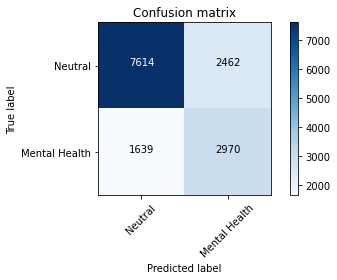

In [358]:
cfn = confusion_matrix(y_test_bin, y_pred)
plot_confusion_matrix(cfn, classes=['Neutral', 'Mental Health'],
                      title='Confusion matrix')

The macro f1 score is .69, precision is .68, and recall is .7.  For the mental health class, the f1-score is .59, precision is .55, and recall is .64. Although the precision for mental health classifications decreases from the previous version of the model, the recall score almost doubles. It catches much more mental health classes this time.  



### Second model to classify which mental health 

I now train a model that takes only individuals who are strugglng with their mental health, and predicts which mental illness they are struggling with. 

In [360]:
#remove entries from the neutral class, and finds the sentence embeddings for the remaining entries
X_train_second = []
y_train_second = []
for i, val in enumerate(y_train):
  if val != 0:
    X_train_second.append(embeddings2[i])
    if val == 6:
      y_train_second.append(0)
    else:
      y_train_second.append(val)
    


In [361]:
X_test_second = []
y_test_second = []
for i, val in enumerate(y_test):
  if val != 0:
    X_test_second.append(embeddings_test[i])
    if val == 6:
      y_test_second.append(0)
    else:
      y_test_second.append(val)
    

In [365]:
hid_dim1 = 768
hid_dim2 = 384
model_sbert_subclass = tf.keras.models.Sequential([
                                             tf.keras.layers.Dense(hid_dim1, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(hid_dim2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(6, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(6, use_bias=False),
                                              tf.keras.layers.Softmax()

])


In [366]:
model_sbert_subclass.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 

In [367]:
history = model_sbert_subclass.fit(x=np.array(X_train_second), y=np.array(y_train_second), validation_split=.20, workers=-1, epochs=15)


Epoch 1/15
471/471 [==============================] - 1s 2ms/step - loss: 1.6638 - accuracy: 0.3136 - val_loss: 1.6540 - val_accuracy: 0.3425
Epoch 2/15
471/471 [==============================] - 1s 2ms/step - loss: 1.6039 - accuracy: 0.3454 - val_loss: 1.6324 - val_accuracy: 0.3468
Epoch 3/15
471/471 [==============================] - 1s 2ms/step - loss: 1.5518 - accuracy: 0.3734 - val_loss: 1.6496 - val_accuracy: 0.3255
Epoch 4/15
471/471 [==============================] - 1s 2ms/step - loss: 1.4869 - accuracy: 0.4062 - val_loss: 1.6367 - val_accuracy: 0.3524
Epoch 5/15
471/471 [==============================] - 1s 2ms/step - loss: 1.4103 - accuracy: 0.4458 - val_loss: 1.6407 - val_accuracy: 0.3667
Epoch 6/15
471/471 [==============================] - 1s 2ms/step - loss: 1.3055 - accuracy: 0.4922 - val_loss: 1.6881 - val_accuracy: 0.3534
Epoch 7/15
471/471 [==============================] - 1s 2ms/step - loss: 1.1915 - accuracy: 0.5460 - val_loss: 1.7707 - val_accuracy: 0.3521
Epoch 

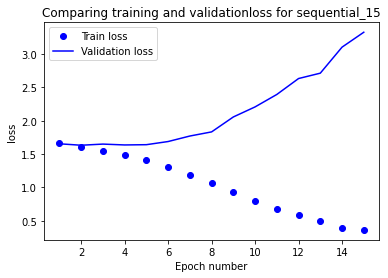

In [368]:
eval_metric(model_sbert_subclass, history, 'loss', ep=15)

According to the graph above, the model begins to overfit after the fourth epoch.  I restart the model, only training it for four epochs. 

In [369]:
hid_dim1 = 768
hid_dim2 = 384
model_sbert_subclass = tf.keras.models.Sequential([
                                             tf.keras.layers.Dense(hid_dim1, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(hid_dim2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(6, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(6, use_bias=False),
                                              tf.keras.layers.Softmax()

])


In [370]:
model_sbert_subclass.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 

In [371]:
history2 = model_sbert_subclass.fit(x=np.array(X_train_second), y=np.array(y_train_second), validation_split=.20, workers=-1, epochs=4)


Epoch 1/4
471/471 [==============================] - 1s 2ms/step - loss: 1.6644 - accuracy: 0.3139 - val_loss: 1.6519 - val_accuracy: 0.3117
Epoch 2/4
471/471 [==============================] - 1s 2ms/step - loss: 1.5965 - accuracy: 0.3501 - val_loss: 1.6389 - val_accuracy: 0.3537
Epoch 3/4
471/471 [==============================] - 1s 2ms/step - loss: 1.5390 - accuracy: 0.3847 - val_loss: 1.6454 - val_accuracy: 0.3271
Epoch 4/4
471/471 [==============================] - 1s 2ms/step - loss: 1.4720 - accuracy: 0.4126 - val_loss: 1.6298 - val_accuracy: 0.3627


In [372]:
score = model_sbert_subclass.evaluate(np.array(X_test_second), np.array(y_test_second), verbose = 1)
score_train = model_sbert_subclass.evaluate(np.array(X_train_second), np.array(y_train_second), verbose = 1)
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']


print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')


y_pred1 = model_sbert_subclass.predict(np.array(X_test_second))
y_pred = np.argmax(y_pred1, axis=1).astype(int)


588/588 [==============================] - 1s 1ms/step - loss: 1.4300 - accuracy: 0.4436
Evaluate on test data
Test loss: 1.6420669555664062 / Test accuracy: 0.3558255732059479
Evaluate on train data
Train loss: 1.4299757480621338 / Train accuracy: 0.4436294138431549


In [373]:
sbert_sub = classification_report(y_test_second, y_pred, output_dict=True)


In [374]:
sbert_sub['anxiety'] = sbert_sub.pop('1')
sbert_sub['adhd'] = sbert_sub.pop('2')
sbert_sub['bipolar'] = sbert_sub.pop('3')
sbert_sub['bpd'] = sbert_sub.pop('4')
sbert_sub['depression'] = sbert_sub.pop('5')
sbert_sub['ptsd'] = sbert_sub.pop('0')


In [375]:
pprint.pprint(sbert_sub)

{'accuracy': 0.3558255586895205,
 'adhd': {'f1-score': 0.14480587618048268,
          'precision': 0.3791208791208791,
          'recall': 0.08949416342412451,
          'support': 771},
 'anxiety': {'f1-score': 0.4614967462039046,
             'precision': 0.3571128829206882,
             'recall': 0.6521072796934866,
             'support': 1305},
 'bipolar': {'f1-score': 0.16216216216216217,
             'precision': 0.3125,
             'recall': 0.10948905109489052,
             'support': 548},
 'bpd': {'f1-score': 0.05179282868525897,
         'precision': 0.2653061224489796,
         'recall': 0.02869757174392936,
         'support': 453},
 'depression': {'f1-score': 0.08888888888888889,
                'precision': 0.26865671641791045,
                'recall': 0.05325443786982249,
                'support': 338},
 'macro avg': {'f1-score': 0.22308300632614578,
               'precision': 0.32417063164142496,
               'recall': 0.24330719564050063,
               'suppor

Confusion matrix, without normalization
[[629 473  32  39   8  13]
 [358 851  43  28   9  16]
 [260 403  69  24   4  11]
 [201 254  16  60  12   5]
 [177 223  12  24  13   4]
 [111 179  10  17   3  18]]


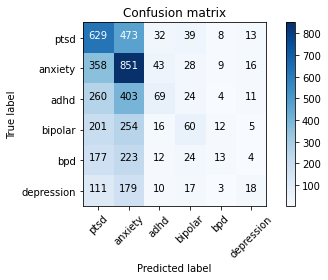

In [377]:
cfn = confusion_matrix(y_test_second, y_pred)
plot_confusion_matrix(cfn, classes=['ptsd', 'anxiety', 'adhd', 'bipolar', 'bpd', 'depression'],
                      title='Confusion matrix')

Overall, the model has a f1 score of .297.  It does best with anxiety (recall of .65 and precision of .36) and PTSD (recall of .53 and precision of .36). Also interestingly, PTSD is misclassified as anxiety 473 times, and anxiety is misclassified as PTSD 358 times. These disorders are closely linked, so it makes sense the model is picking up on this. 




In [381]:
hid_dim1 = 768
hid_dim2 = 384
model_sbert_subclass_cw = tf.keras.models.Sequential([
                                             tf.keras.layers.Dense(hid_dim1, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(hid_dim2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(6, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(6, use_bias=False),
                                              tf.keras.layers.Softmax()

])


In [382]:
model_sbert_subclass_cw.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 

In [383]:
#calculate the class weights for the model
unique = np.unique(y_train_second)
class_weights = class_weight.compute_class_weight('balanced', unique, y_train_second)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.6264735264735265,
 1: 0.5900451637184795,
 2: 1.047261189044756,
 3: 1.3503445305770887,
 4: 1.7371191135734072,
 5: 2.283685360524399}

In [384]:
history3 = model_sbert_subclass_cw.fit(x=np.array(X_train_second), y=np.array(y_train_second), validation_split=.20, class_weight=class_weight_dict, workers=-1, epochs=15)


Epoch 1/15
471/471 [==============================] - 2s 3ms/step - loss: 1.7714 - accuracy: 0.1783 - val_loss: 1.7898 - val_accuracy: 0.1927
Epoch 2/15
471/471 [==============================] - 1s 2ms/step - loss: 1.7126 - accuracy: 0.2290 - val_loss: 1.7515 - val_accuracy: 0.2341
Epoch 3/15
471/471 [==============================] - 1s 2ms/step - loss: 1.6574 - accuracy: 0.2702 - val_loss: 1.7289 - val_accuracy: 0.2556
Epoch 4/15
471/471 [==============================] - 1s 2ms/step - loss: 1.5917 - accuracy: 0.3014 - val_loss: 1.7219 - val_accuracy: 0.2679
Epoch 5/15
471/471 [==============================] - 1s 2ms/step - loss: 1.5111 - accuracy: 0.3374 - val_loss: 1.7734 - val_accuracy: 0.2788
Epoch 6/15
471/471 [==============================] - 1s 2ms/step - loss: 1.4098 - accuracy: 0.3819 - val_loss: 1.7751 - val_accuracy: 0.2798
Epoch 7/15
471/471 [==============================] - 1s 2ms/step - loss: 1.2820 - accuracy: 0.4371 - val_loss: 1.8925 - val_accuracy: 0.2958
Epoch 

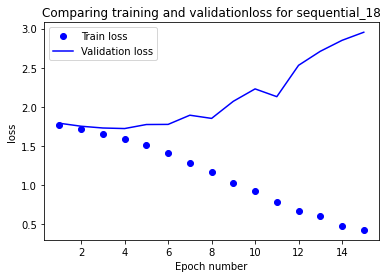

In [385]:
eval_metric(model_sbert_subclass_cw, history3, 'loss', ep=15)

This model also begins to overfit around the fourth epoch. 

In [386]:
hid_dim1 = 768
hid_dim2 = 384
model_sbert_subclass_cw = tf.keras.models.Sequential([
                                             tf.keras.layers.Dense(hid_dim1, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(hid_dim2, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(6, activation=tf.nn.leaky_relu),
                                             tf.keras.layers.Dense(6, use_bias=False),
                                              tf.keras.layers.Softmax()

])

In [387]:
model_sbert_subclass_cw.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 

In [388]:
history3 = model_sbert_subclass_cw.fit(x=np.array(X_train_second), y=np.array(y_train_second), validation_split=.20, class_weight=class_weight_dict, workers=-1, epochs=4)


Epoch 1/4
471/471 [==============================] - 2s 3ms/step - loss: 1.7744 - accuracy: 0.2008 - val_loss: 1.7594 - val_accuracy: 0.2171
Epoch 2/4
471/471 [==============================] - 1s 2ms/step - loss: 1.7215 - accuracy: 0.2380 - val_loss: 1.7540 - val_accuracy: 0.2312
Epoch 3/4
471/471 [==============================] - 1s 2ms/step - loss: 1.6592 - accuracy: 0.2829 - val_loss: 1.7306 - val_accuracy: 0.2580
Epoch 4/4
471/471 [==============================] - 1s 2ms/step - loss: 1.5845 - accuracy: 0.3247 - val_loss: 1.7120 - val_accuracy: 0.2796


In [389]:
score = model_sbert_subclass_cw.evaluate(np.array(X_test_second), np.array(y_test_second), verbose = 1)
score_train = model_sbert_subclass_cw.evaluate(np.array(X_train_second), np.array(y_train_second), verbose = 1)


print("Evaluate on test data")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print("Evaluate on train data")
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')


y_pred1 = model_sbert_subclass_cw.predict(np.array(X_test_second))
y_pred = np.argmax(y_pred1, axis=1).astype(int)

588/588 [==============================] - 1s 1ms/step - loss: 1.5254 - accuracy: 0.3787
Evaluate on test data
Test loss: 1.717745304107666 / Test accuracy: 0.2748969495296478
Evaluate on train data
Train loss: 1.5254179239273071 / Train accuracy: 0.37867432832717896


In [390]:
sbert_sub_cw = classification_report(y_test_second, y_pred, output_dict=True)


In [391]:
sbert_sub_cw['anxiety'] = sbert_sub_cw.pop('1')
sbert_sub_cw['adhd'] = sbert_sub_cw.pop('2')
sbert_sub_cw['bipolar'] = sbert_sub_cw.pop('3')
sbert_sub_cw['bpd'] = sbert_sub_cw.pop('4')
sbert_sub_cw['depression'] = sbert_sub_cw.pop('5')
sbert_sub_cw['ptsd'] = sbert_sub_cw.pop('0')

In [392]:
pprint.pprint(sbert_sub_cw)

{'accuracy': 0.2748969407680625,
 'adhd': {'f1-score': 0.26192075218267297,
          'precision': 0.27158774373259054,
          'recall': 0.2529182879377432,
          'support': 771},
 'anxiety': {'f1-score': 0.25418060200668896,
             'precision': 0.4662576687116564,
             'recall': 0.17471264367816092,
             'support': 1305},
 'bipolar': {'f1-score': 0.27674418604651163,
             'precision': 0.2030716723549488,
             'recall': 0.4343065693430657,
             'support': 548},
 'bpd': {'f1-score': 0.23353819139596138,
         'precision': 0.19387755102040816,
         'recall': 0.293598233995585,
         'support': 453},
 'depression': {'f1-score': 0.17464788732394362,
                'precision': 0.16666666666666666,
                'recall': 0.1834319526627219,
                'support': 338},
 'macro avg': {'f1-score': 0.2580755713193415,
               'precision': 0.27535731605715436,
               'recall': 0.2805314655241525,
             

Confusion matrix, without normalization
[[411  90 132 331 157  73]
 [285 228 213 261 185 133]
 [200  64 195 164  94  54]
 [113  39  69 238  63  26]
 [ 96  35  56 109 133  24]
 [ 67  33  53  69  54  62]]


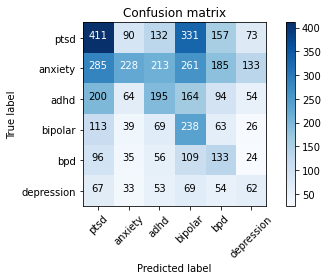

In [393]:
cfn = confusion_matrix(y_test_second, y_pred)
plot_confusion_matrix(cfn, classes=['ptsd', 'anxiety', 'adhd', 'bipolar', 'bpd', 'depression'],
                      title='Confusion matrix')

This model has a weighted f1-score of .27, precision of .32, and recall of .27.  ADHD's recall and precision are similiar to each other at .25 and .27.  Anxiety's precision is .47 and recall is .17.  Bipolar's recall is .43 but precision is .2.  BPD's recall is .29 and precision is .19.  Depression has a recall of .18 and precision of .17.  PTSD's recall is .34 and precision is .35. Interestingly, in this model PTSD is linked more closely to bipolar than anxiety.  

# Conclusions 

Posts in non-mental health subreddits can also show a lot about whether someone is struggling with their mental health, whether from patterns in speech or from the content of the posts. I was able to train a model on non-mental health related social media posts that could classify users as struggling with their mental health or not, but was unable to train a model solely on non-mental health posts that could classfy which mental health illness someone is likely to have with a high degree of precision or recall. The models struggled to distinguish between the disorders. 



## Business Recommendations 

*   Create an online support group: Many people form strong relationships and groups online.  Some people feel more comfortable opening up when not having to speak out loud or show their face.  Creating a support group that's entirely online could be very successful and helpful for individuals. 
*   Respond to users: Talk about the benefits of counseling, programs the agency offers, post information.  Always obey subreddit/community rules! 
*   Subreddits of note: AskReddit, Relationships, RelationshipAdvice, AmITheAsshole - had high post rates for users struggling wth their mental health.  Monitor those subreddits as well as the subreddits focused on mental health. 

## Future Work

*   Continue to refine the models to analyze language
*   Creating an informational and encouraging (not too positive) bot 
*   Examine comorbidity and how it could affect language


